<a href="https://colab.research.google.com/github/Eladweller/Book-Recommender/blob/master/Covid_19_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [204]:
# %%capture
import os
from os.path import join  
from google.colab import drive
drive.mount('/content/drive')
ROOT="/content/drive/My Drive/Coronavirus/"
# path = ""
!pip install python-pptx
!pip install https://github.com/Phlya/adjustText/archive/master.zip
presentation_folder_name = "Presentations/"
presentations_path = ROOT+presentation_folder_name
graph_folder_name = "New_Graphs/"
graphs_path = ROOT+graph_folder_name
data_folder_name = "data/"
data_path = ROOT+data_folder_name
for path in [presentations_path,graphs_path,data_path]:
  if not os.path.exists(path):
    os.makedirs(path)

README = []

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached https://github.com/Phlya/adjustText/archive/master.zip
  Created wheel for adjustText: filename=adjustText-0.7.4-cp36-none-any.whl size=8697 sha256=0288edeff9309809ffe8e76d54fabdb6c1b521d66683f9977ded0a3ae8155b03
  Stored in directory: /tmp/pip-ephem-wheel-cache-f2dbi_zp/wheels/7a/56/aa/ee86b18565ad149ba3a5470b55bbc5081701fd0b57141ed055
Successfully built adjustText


# Importation

In [0]:
from io import BytesIO
image_stream = BytesIO()
import pptx
from pptx import Presentation
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as ticker
import seaborn as sns
import pandas.util.testing as tm ## just to avoid warning when importing seaborn
style.use('fivethirtyeight')
from matplotlib.scale import LinearScale
import urllib.request as request
import csv
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.offsetbox import AnchoredText
from cycler import cycler
default_cycler = (cycler(linestyle=['-','--',':']) * cycler(color=['royalblue','orangered','black','g','mediumturquoise','deepskyblue','firebrick', 'peru','olive','orange']))
plt.rc('axes', prop_cycle=default_cycler)
import numpy as np
from IPython.display import display
from adjustText import adjust_text
import requests
import json
import sys
url_confirmed='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_dead='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
from datetime import datetime
NOW = datetime.now()
import math

# Functions

## Save to PPTX functions

In [0]:
from pptx.dml.color import RGBColor

class ToSlide:
    def __init__(self,data):
        self.layout = prs.slide_layouts[8]
        self.slide = prs.slides.add_slide(self.layout)
        self.title = self.slide.shapes.title
        # self.title.text = data[0]
        self.subtitle = self.slide.placeholders[2]
        # self.subtitle.text = data[2]
        self.picture = self.slide.placeholders[1]
        sp = self.picture._sp
        sp.getparent().remove(sp)
        size = data[3]
        ratio = size[0]/size[1]
        print(size)
        if size[1]>=size[0]:          
          print('111')
          height = min(size[1],7)
          width = height*ratio
        else:
          print('222')
          width = min(9,size[0])
          height = width/ratio 
        top_pos = (7.5-height)/2
        left_pos = (10-width)/2
        print(height,width,top_pos,left_pos)
        shape1 = self.slide.shapes.add_picture(data[1], pptx.util.Inches(left_pos), pptx.util.Inches(top_pos),
                               width=pptx.util.Inches(width), height=pptx.util.Inches(height))
        # prs.save(ppt_loc)

class SavetoPPT:
  def __init__(self):
    self.title = ""
    self.subtitle = ""
    self.image_stream = BytesIO()
    plt.savefig(self.image_stream)

  def set_plot(self,plot):
    self.plot = plot

  def set_title(self,s):
    self.title = s

  def set_subtitle(self,s):
    self.subtitle = s

  def send(self):
      ToSlide([self.title,self.image_stream,self.subtitle])

def to_pptx(s1,s2,plot):
  image_stream = BytesIO()
  plt.savefig(image_stream, bbox_inches='tight')
  size = plt.gcf().get_size_inches()
  ToSlide([s1,image_stream,s2,size])

def add_bullet(box,text,level = 0,bold = False, color = RGBColor(0, 0, 0)):
  p = box.text_frame.add_paragraph()
  p.font.bold = bold
  p.font.color.rgb = color
  p.level = level
  p.text = text

## General application functions

In [0]:
def download_csv(url,dataname):
  r = request.urlopen(url).read().decode('utf8').split("\n")
  filename=url.split("/")[-1]
  reader = csv.reader(r)
  lines=[]
  columns=next(reader)
  for line in reader:
      lines.append(line)
  df=pd.DataFrame(lines,columns=columns).dropna(how='any').drop(['Lat','Long'],axis=1).replace('',0)
  df=df.set_index(['Country/Region','Province/State']).astype('int64')
  df=df.reset_index().groupby('Country/Region').sum().drop(['Diamond Princess','MS Zaandam'],axis=0)
  df.to_csv(data_path+filename)
  df = df.unstack().reset_index(drop=False).rename({'level_0':'date','Country/Region':'country',0:dataname},axis='columns')
  df.date = pd.to_datetime(df.date)
  return df

def datestring(date):
  return date.strftime('%d-%m-%Y')

def ctime(date):
  return date.strftime("%B %-d, %Y")

def get_latest_leader(column):
  column_rank = "{}_rank".format(column)
  res = covid.loc[(covid[column_rank]==1) & (covid.date == last_date)].T
  return res.loc['country'].values[0],res.loc[column].values[0]

def exporter(t,st=''):
  to_pptx(t,st,ax)
  if st !='':
    st = "({})".format(st)
  plt.savefig(graphs_path+t+st+'.png', bbox_inches='tight')
  README.append([t + st])

def keep_relevant_countries(df,relevant_countries):
  return df[df.country.isin(relevant_countries)]

def get_line_attributes(plotline):
    label = plotline.get_label()
    color = plotline.get_color()
    r_edge = [i for i in plotline.get_xydata() if True not in np.isnan(i)][-1]
    alpha = plotline.get_alpha()
    return {'label':label,'color':color,'r_edge':r_edge,'alpha':alpha}

def labelize(ax,adj_text = False,show_values = False,show_date=False):
  annotations = []
  for line in ax.lines:
    label = line.get_label()
    # left_edge_x,left_edge_y = line.get_xydata()[0]
    right_edge_x,right_edge_y = [(x,y) for x,y in line.get_xydata() if not np.isnan(y)][-1]
    color = line.get_color()
    alpha = line.get_alpha()
    if not label.startswith("_"):
      _label = label
      if show_values:
        _label += "\n{0:0,.0f}".format(right_edge_y)
      if show_date:
        _label += "\n({})".format(datestring(last_date))
      annotations.append(ax.annotate(s=_label,xy=(right_edge_x,right_edge_y), c=color,fontsize = 10,ha = 'left'))
  if adj_text == True:
    adjust_text(annotations,arrowprops=dict(arrowstyle="-", color=color, lw=0.5))

def draw_exponent(axis, days = [2,3,5],start_value=100):
  plots=[]
  size = np.linspace(0, axis.get_xlim()[1])
  ylim = axis.get_ylim()[1]
  for t in days:
    exp = 2 ** (1/t)
    y = start_value * (exp) ** size
    keep = np.where(y<=ylim)
    l1 = plt.plot(size[keep], y[keep],ls='--', color='grey', label='multiply every {} days'.format(t), alpha = .25)
    atts = get_line_attributes(l1[0])
    plt.annotate(s = atts['label'], xy = atts['r_edge'], c = atts['color'],size = 10,alpha = atts['alpha']*2)

def expand_xlim(graph,left=0,right=0):
  low,high = graph.get_xlim()
  graph.set_xlim(low-left,high+right)

def plot_hline(ax):
  ax.axhline(y = ax.get_ylim()[0]+2, color = 'black', linewidth = 1.3, alpha = .7)

def return_k(x, y=0):
  if x>=1000000:
    return '{0:0.0f}m'.format(x/1000000)
  elif x>=10000:
    return '{0:0.0f}k'.format(x/1000)
  elif x>=1000:
    if x%1000 == 0:
      return '{0:0.0f}k'.format(x/1000)
    else:
      return '{0:0.1f}k'.format(x/1000)
  else:
    if x/int(x) == 1:
      return '{0:0,.0f}'.format(x)
    else:
      return '{0:0.1f}'.format(x)

def return_comma_format(x,y=0):
  if x>=1000:
    return '{0:0.0f}'.format(x)
  else:
    return '{}'.format(x)


def add_signature (y1,size=10):
  plt.text(x=.025,y=y1,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey',size=size)
  plt.text(x=.975,y=y1,s='Source: "Johns Hopkins CSSE" (latest data: {})'.format(ctime(last_date)),ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey',size=size)

def add_title(y1,title,subtitle='',offset = .04,size=34):
  y2 = y1-offset
  plt.text(x=.025,y=y1,s=title,ha = 'left', va = 'top', transform=fig.transFigure,color='black',size=size,weight = 'bold',alpha = .8)
  plt.text(x=.025,y=y2,s=subtitle,ha = 'left', va = 'top', transform=fig.transFigure,color='black',size=size*.55, alpha = .8,wrap=True)

# Data preperation

## Download COVID-19 Statistics from git-hub

In [0]:
confirmed = download_csv(url_confirmed,'confirmed')
dead=download_csv(url_dead,'dead')
recovered = download_csv(url_recovered,'recovered')

covid = pd.merge(confirmed,dead,how = 'inner',on=['date','country'])
covid = pd.merge(covid,recovered,how = 'inner',on=['date','country'])
covid['active'] = covid.confirmed - covid.dead - covid.recovered


last_date=pd.to_datetime(covid.date.max())
ten_days_ago=last_date - pd.to_timedelta('10 days')
week_ago = last_date - pd.to_timedelta('7 days')

## Get population data for countries

In [0]:
not_found=[]
rename = {'Congo (Brazzaville)':"Congo-Brazzaville",
          'Congo (Kinshasa)':"DRC",
          'Czechia':"CZ",
          'Korea, South':"KR",
          'North Macedonia':"MK",
          'Taiwan*': 'TW',
          'occupied Palestinian territory':"PS",
          'Republic of the Congo':'Congo-Brazzaville',
          'Gambia, The': 'GM',
          'Bahamas, The': 'Bahamas',
          'Cape Verde': 'CV',
          'West Bank and Gaza': 'PS'

}
countries = covid.country.unique()
population = {}
for country in countries:
  try:
    response = json.loads(requests.get('https://restcountries.eu/rest/v2/name/{}'.format(country)).text)
    population[country] = response[0]['population']
  except:
    response = json.loads(requests.get('https://restcountries.eu/rest/v2/name/{}'.format(rename[country])).text)
    population[country] = response[0]['population']

population['Congo (Kinshasa)'] = 85026000
population['India'] = 1295210000
population['Sudan'] = 39598700
population['US'] = 323947000

pop = covid.country.map(population)

## Normalize data by population

In [0]:
covid['confirmed_per_1m'] = covid.confirmed/pop * 1000000
covid['dead_per_1m'] = covid.dead/pop*1000000

## Calculate Mortality Rate



In [0]:
covid['mortality_rate'] = covid.dead/covid.confirmed
covid['mortality_rate_change'] = covid.mortality_rate - covid.groupby('country')['mortality_rate'].shift(1)

## Create daily change data

In [0]:
covid['confirmed_daily'] = covid.confirmed - covid.groupby(['country'])['confirmed'].shift(1)
covid['confirmed_daily_change'] = (covid.confirmed_daily / covid.groupby(['country'])['confirmed'].shift(1)).replace(np.inf,np.nan)
covid['confirmed_10_day_change'] = (covid.confirmed / covid.groupby(['country'])['confirmed'].shift(10)).replace(np.inf,np.nan)
covid['confirmed_daily_10_day_mean'] = covid.groupby('country')['confirmed_daily'].rolling(10).mean().reset_index().sort_values('level_1').set_index('level_1').confirmed_daily
covid['confirmed_daily_5_day_change_mean'] = covid.groupby('country')['confirmed_daily_change'].rolling(5).mean().reset_index().sort_values('level_1').set_index('level_1').confirmed_daily_change
covid['dead_daily'] = covid.dead - covid.groupby(['country'])['dead'].shift(1)
covid['dead_daily_change'] = (covid.dead_daily / covid.groupby(['country'])['dead'].shift(1)).replace(np.inf,np.nan)
covid['dead_10_day_change'] = (covid.dead / covid.groupby(['country'])['dead'].shift(10)).replace(np.inf,np.nan)
covid['dead_daily_10_day_mean'] = covid.groupby('country')['dead_daily'].rolling(10).mean().reset_index().sort_values('level_1').set_index('level_1').dead_daily
covid['dead_daily_5_day_change_mean'] = covid.groupby('country')['dead_daily_change'].rolling(5).mean().reset_index().sort_values('level_1').set_index('level_1').dead_daily_change

## Rank countries

In [0]:
ranks = covid.groupby('date').rank(method = 'dense', ascending = False).add_suffix('_rank')
covid = pd.concat([covid,ranks],axis=1)

In [0]:
covid.to_csv(data_path+'COVID-19 data.csv',index = False)

## Calculate Daily Totals

### World

In [216]:
totals = covid.groupby('date')['confirmed','dead','active'].sum()
totals['recovered'] = totals.confirmed - totals.active - totals.dead
totals['confirmed_daily'] = totals.confirmed - totals.confirmed.shift(1)
totals['confirmed_daily_change'] = totals.confirmed_daily / totals.confirmed.shift(1)
totals['dead_daily'] = totals.dead - totals.dead.shift(1)
totals['dead_daily_change'] = totals.dead_daily / totals.dead.shift(1)
totals['mortality_rate'] = totals.dead / totals.confirmed
totals['mortality_rate_change'] = (totals.mortality_rate - totals.mortality_rate.shift(1)).replace(np.inf,np.nan)
totals.to_csv(path+'COVID-19 daily')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


### Israel

In [0]:
Israel = covid[covid.country == 'Israel'].set_index('date',drop=True)

## Extract latest data

In [0]:
total_cases = totals.confirmed[-1]
new_cases = totals.confirmed_daily[-1]
new_cases_growth = int(totals.confirmed_daily_change[-1]*100)
total_fatals = totals.dead[-1]
new_fatals = totals.dead_daily[-1]
new_fatals_growth = int(totals.dead_daily_change[-1]*100)
ten_days_increase_confirmed = totals.loc[last_date].confirmed/totals.loc[ten_days_ago].confirmed
ten_days_increase_dead = totals.loc[last_date].dead/totals.loc[ten_days_ago].dead

leaders = {cat:get_latest_leader(cat) for cat in ['confirmed','dead','confirmed_per_1m','dead_per_1m','mortality_rate','confirmed_daily','confirmed_daily_change','dead_daily','dead_daily_change']}

# Initialize Presentation

## Creating *prs* as *Presentation()* type object

In [0]:
prs = Presentation()
ppt_loc = presentations_path+'COVID-19 {}.pptx'.format(datestring(last_date))

## initializing Introduction slide


In [0]:
layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(layout)
title = slide.shapes.title
title.text = "COVID-19 Statistics"
subtitle = slide.placeholders[1]
subtitle.text = datestring(last_date)

## Creating the first slide


In [0]:
layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(layout)
title = slide.shapes.title
title.text = "Latest Statistics\n(updated {})".format(datestring(last_date))
subtitle = slide.placeholders[1]
subtitle.text = "Total confirmed cases worldwide: {0:0,.0f}".format(total_cases)
add_bullet(subtitle,"{0:0,.0f} new cases ({1}% increase)".format(new_cases,new_cases_growth))
add_bullet(subtitle,"Total fatal cases worldwide: {0:0,.0f}".format(total_fatals))
add_bullet(subtitle,"{0:0,.0f} new fatalities ({1}% increase)".format(new_fatals,new_fatals_growth),)
add_bullet(subtitle,"Israel recorded {0:0,.0f} cases in total".format(Israel.confirmed.iloc[-1]), color = RGBColor(0, 0, 255))
add_bullet(subtitle,"increased by {0:0,.0f} cases ({1}% increase)".format(Israel.confirmed_daily.iloc[-1],int(Israel.confirmed_daily_change.iloc[-1]*100)), color = RGBColor(0, 0, 255))
add_bullet(subtitle,"{}# in confirmed cases, {}# in mortality".format(Israel.confirmed_rank.iloc[-1],Israel.dead_rank.iloc[-1]),color = RGBColor(0, 0, 255) )
add_bullet(subtitle,"{}# in cases per capita, {}# in mortality rate".format(Israel.confirmed_per_1m_rank.iloc[-1],Israel.dead_per_1m_rank.iloc[-1]),color = RGBColor(0, 0, 255) )

## Creating the second slide

In [0]:
layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(layout)
title = slide.shapes.title
title.text = "Latest Statistics\n(updated {})".format(datestring(last_date))
subtitle = slide.placeholders[1]
subtitle.text = "Worldwide mortality rate: {0:0,.1f}% ({2}{1:0,.1f}%)".format(totals.mortality_rate[-1]*100,totals.mortality_rate_change[-1]*100,"+" if totals.mortality_rate_change[-1]>0 else "")
add_bullet(subtitle,"Israel mortality rate: {0:0,.1f}% ({2}{1:0,.1f}%)".format(Israel.mortality_rate[-1]*100,Israel.mortality_rate_change[-1]*100,"+" if Israel.mortality_rate_change[-1]>0 else ""), color = RGBColor(0, 0, 255))
add_bullet(subtitle,"{0} has most cases in total ({1:,d})".format(leaders['confirmed'][0],leaders['confirmed'][1]))
add_bullet(subtitle,"{0} has most fatal cases in total ({1:s})".format(leaders['dead'][0],leaders['confirmed'][0],leaders['confirmed'][1]))
add_bullet(subtitle,"{0} recorded the most new cases ({1:0,.0f})".format(leaders['confirmed_daily'][0],leaders['confirmed_daily'][1]))
add_bullet(subtitle,"{0} recorded the most new fatal cases ({1:0,.0f})".format(leaders['dead_daily'][0],leaders['dead_daily'][1]))

## Saving the slide to file "COVID-19.pptx"

In [0]:
prs.save(ppt_loc)

# Plot the data

## Israel on Key Metrics

### Last week's Progression

[10. 12.]
111
7 5.833333333333334 0.25 2.083333333333333


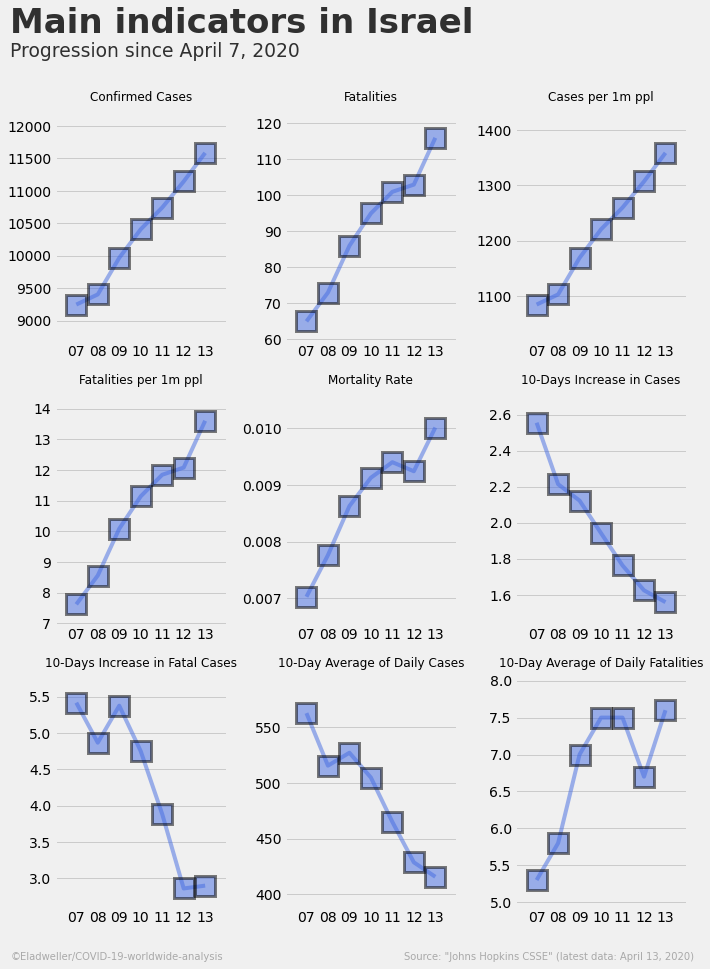

In [224]:
titles = {'confirmed_10_day_change': "10-Days Increase in Cases",
          'confirmed_daily_10_day_mean': '10-Day Average of Daily Cases',
          'confirmed_per_1m': 'Cases per 1m ppl',
          'confirmed': 'Confirmed Cases',
          'dead_10_day_change': "10-Days Increase in Fatal Cases",
          'dead_daily_10_day_mean': '10-Day Average of Daily Fatalities',
          'dead_per_1m': 'Fatalities per 1m ppl',
          'dead': 'Fatalities',
          'mortality_rate': 'Mortality Rate'}

relevant_columns = ['confirmed','dead','confirmed_per_1m','dead_per_1m','mortality_rate','confirmed_10_day_change','dead_10_day_change','confirmed_daily_10_day_mean','dead_daily_10_day_mean']
Israel_last_week = Israel[week_ago+pd.to_timedelta('1 day'):last_date]
World_last_week = totals[week_ago+pd.to_timedelta('1 day'):last_date]
nrows = 3
ncols = 3

fig,axes = plt.subplots(nrows = nrows,ncols = ncols, figsize = (10,12))
for idx,c in enumerate(relevant_columns):
  subset = Israel_last_week[c]
  ax = axes[idx//ncols,idx%ncols]
  ax.set_title(titles[c],fontdict={'size':12})
  subset.plot(style = '-s',markersize=20,alpha=0.5,markeredgecolor='black',markeredgewidth=3,ax=ax)
  ax.set_xlabel("")
  xleft,xright = ax.get_xlim()
  ybottom,ytop = ax.get_ylim()
  ax.set_ylim(.95*ybottom,1.05*ytop)
  ax.set_xlim(xleft-1,xright+1)
  xticks = ax.xaxis.get_major_ticks()
  xticks[0].label1.set_visible(False)
  xticks[-1].label1.set_visible(False)
plt.tight_layout()

## set title
add_title(1.08,"Main indicators in Israel","Progression since {}".format(ctime(week_ago+pd.to_timedelta('1 day'))))
## set signature
add_signature(-.025)
exporter("Main indicators in Israel","Progression in the last week")

### Israel's Rankings

[10. 12.]
111
7 5.833333333333334 0.25 2.083333333333333


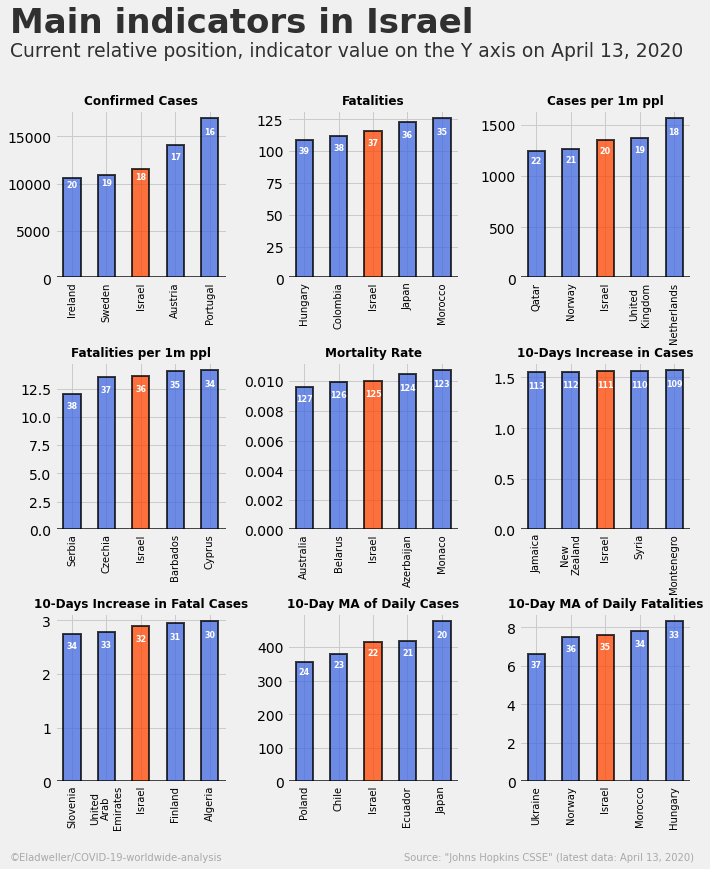

In [225]:
titles = {'confirmed_10_day_change_rank': "10-Days Increase in Cases",
          'confirmed_daily_10_day_mean_rank': '10-Day MA of Daily Cases',
          'confirmed_per_1m_rank': 'Cases per 1m ppl',
          'confirmed_rank': 'Confirmed Cases',
          'dead_10_day_change_rank': "10-Days Increase in Fatal Cases",
          'dead_daily_10_day_mean_rank': '10-Day MA of Daily Fatalities',
          'dead_per_1m_rank': 'Fatalities per 1m ppl',
          'dead_rank': 'Fatalities',
          'mortality_rate_rank': 'Mortality Rate'}

relevant_columns = ['confirmed_rank','dead_rank','confirmed_per_1m_rank','dead_per_1m_rank','mortality_rate_rank','confirmed_10_day_change_rank','dead_10_day_change_rank','confirmed_daily_10_day_mean_rank','dead_daily_10_day_mean_rank']
Israel_today_rank = covid[(covid.country == 'Israel') & (covid.date == last_date)][relevant_columns]
Israel_today_rank = Israel_today_rank.to_dict('list')
covid_today = covid[covid.date == last_date]
nrows = 3
ncols = 3

fig,axes = plt.subplots(nrows = nrows,ncols = ncols, figsize = (10,12))
for idx,(k,v) in enumerate(Israel_today_rank.items()):
  ax = axes[idx//ncols,idx%ncols]
  value = int(v[0])
  rank_range = list(range(value-2,value+3))
  subset = covid_today[covid_today[k].isin(rank_range)].sort_values(k,ascending = False).set_index('country',drop=True).loc[:,[k,k.split('_rank')[0]]]
  p = subset.plot(kind = 'bar',y=k.split('_rank')[0],ax=ax,legend=None, color = np.where(subset.index == 'Israel','orangered','royalblue'),linewidth=2,edgecolor = 'black',alpha = .75)
  ax.set_xlabel(None)
  ax.tick_params(axis='x', which='major', labelsize=7)
  ax.set_title(titles[k],fontdict = {'size' : 12, 'weight' : 'bold'})
  ax.axhline(y=0, c='k', alpha = .7)
  for idx2, patch in enumerate(p.patches):
    x1,x2 = patch.get_xy()
    height = patch.get_height()
    color = patch.get_facecolor()
    ax.annotate(s = "{0:0.0f}".format(subset[k][idx2]),xy = (x1+.25,0.9*height),size = 8,c = 'white',weight='bold',ha='center')
  ax.set_xticklabels(["\n".join(c.split()) for c in subset.index])
  ax.tick_params(axis="x", labelsize=10)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
ax.get_xmajorticklabels()

add_title(.97,"Main indicators in Israel","Current relative position, indicator value on the Y axis on {}".format(ctime(last_date)))
add_signature(-0.02)
exporter('Israel on Key Metrics')

### Israel's Rankings Change

[10. 12.]
111
7 5.833333333333334 0.25 2.083333333333333


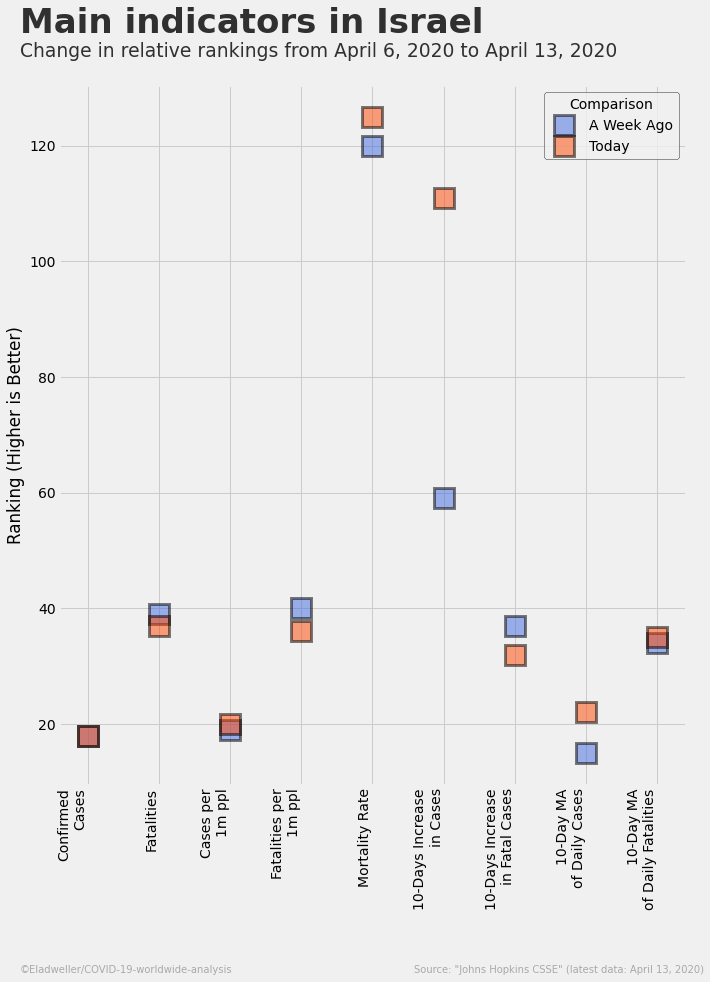

In [226]:
titles = {'confirmed_10_day_change_rank': "10-Days Increase\nin Cases",
          'confirmed_daily_10_day_mean_rank': '10-Day MA\nof Daily Cases',
          'confirmed_per_1m_rank': 'Cases per\n1m ppl',
          'confirmed_rank': 'Confirmed\nCases',
          'dead_10_day_change_rank': "10-Days Increase\nin Fatal Cases",
          'dead_daily_10_day_mean_rank': '10-Day MA\nof Daily Fatalities',
          'dead_per_1m_rank': 'Fatalities per\n1m ppl',
          'dead_rank': 'Fatalities',
          'mortality_rate_rank': 'Mortality Rate'}

relevant_columns = ['date','confirmed_rank','dead_rank','confirmed_per_1m_rank','dead_per_1m_rank','mortality_rate_rank','confirmed_10_day_change_rank','dead_10_day_change_rank','confirmed_daily_10_day_mean_rank','dead_daily_10_day_mean_rank']

fig,ax = plt.subplots(figsize = (10,12))

subset = covid[(covid.country == 'Israel') & ((covid.date == last_date) | (covid.date == week_ago))][relevant_columns].rename({'date':'Date'},axis=1).set_index('Date',drop=True).rename({last_date:'Today',week_ago:'A Week Ago'})
subset.T.plot(style='s',ax=ax,markersize=20,alpha=0.5,markeredgecolor='black',markeredgewidth=3)
plt.xticks(rotation=90,ha='right')
ax.set_xticklabels([titles[i.get_text()] for i in plt.gca().xaxis.get_majorticklabels() if i.get_text() in titles])
ax.set_ylabel('Ranking (Higher is Better)')
plt.legend(title="Comparison",edgecolor="black")


## set title signature
add_title(.97,"Main indicators in Israel","Change in relative rankings from {} to {}".format(ctime(week_ago),ctime(last_date)))
## set signature
add_signature(-.15)
## export to .pptx and .png
exporter("Changes in Israel's Rankings from Last Week")

## Worldwide Status Update

### Plot world total of *confirmed* cases and *mortality* cases

[15. 10.]
222
6.0 9 0.75 0.5


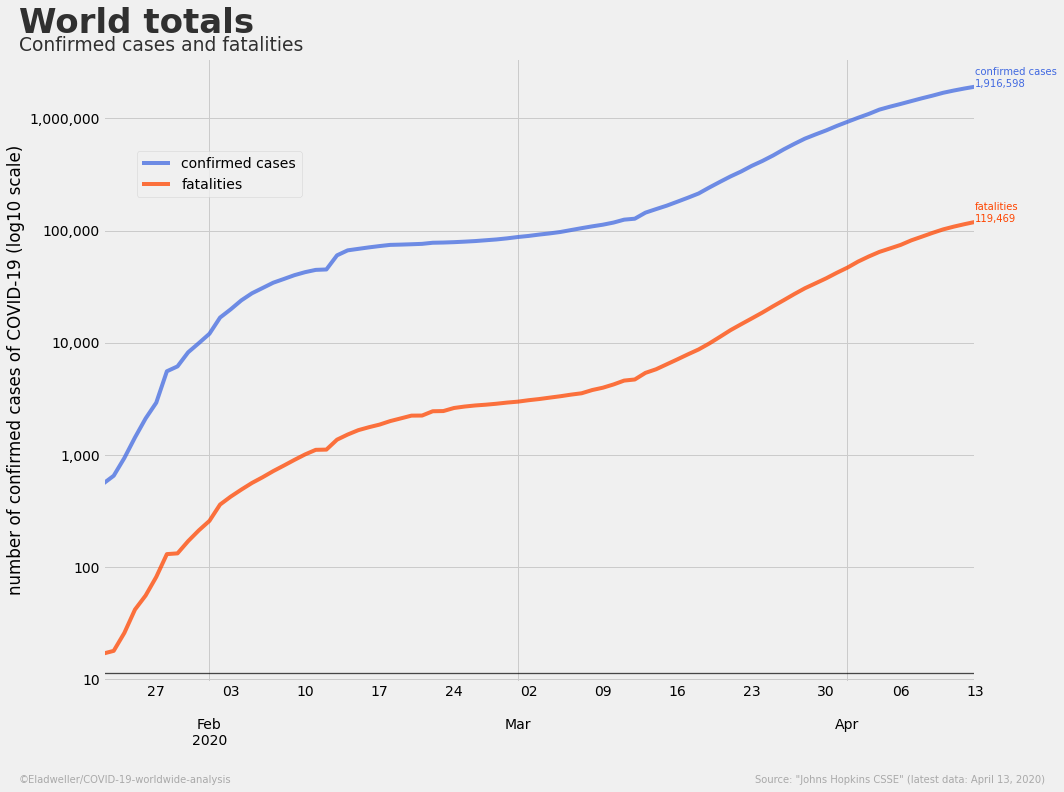

In [227]:
fig,ax = plt.subplots (figsize = (15,10))
ax.set_ylabel('number of confirmed cases of COVID-19 (log10 scale)' )
l1 = totals.confirmed.plot(ax = ax, color = 'royalblue', label = 'confirmed cases', alpha = .75)
l2 = totals.dead.plot (ax = ax , color = 'orangered' , label = 'fatalities',alpha = .75)
plt.yscale('log')
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
fig.legend(loc = 'upper left',bbox_to_anchor=[0.12, .9])
labelize(ax,show_values=True)
plot_hline(ax)
ax.set_xlabel(None)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,y: '{0:0,.0f}'.format(x)))
plt.tight_layout()

## set title
add_title(1.05,'World totals','Confirmed cases and fatalities')
## set_signature
add_signature(-.03)
exporter("COVID-19 confirmed cases vs COVID-19 fatalities, logarithmic scale")

### Plot top 20 countries in *confirmed* cases, *mortality* cases and *mortality rate*

[9. 4.]
222
4.0 9 1.75 0.5
[9. 4.]
222
4.0 9 1.75 0.5
[9. 4.]
222
4.0 9 1.75 0.5


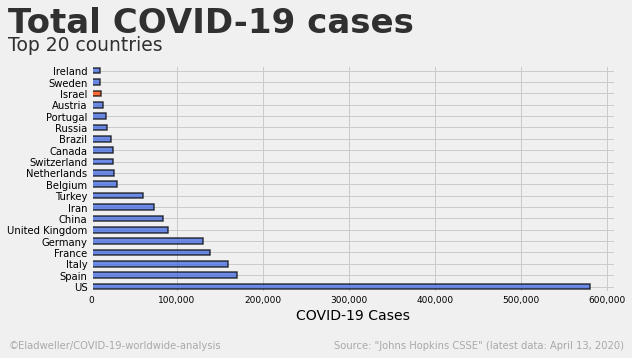

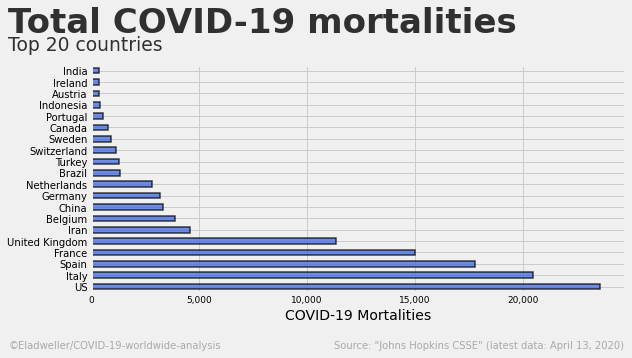

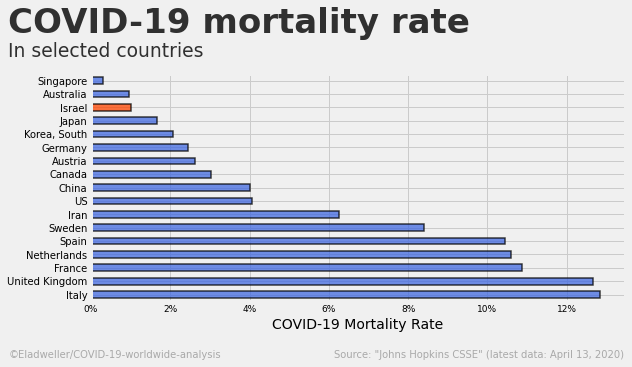

In [228]:
fig,ax = plt.subplots(figsize = (9,4))
subset = covid[covid.date == last_date].groupby('country').sum()['confirmed'].sort_values(ascending = False).head(20)
p = subset.plot(kind='barh', ax = ax, color=np.where(subset.index == 'Israel','orangered','royalblue'),linewidth=1.5,edgecolor = 'black',alpha = .75)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.tick_params(axis='x', which='major', labelsize=9)
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("COVID-19 Cases",fontdict={'size':14})
ax.set_ylabel('')
plt.tight_layout()
add_title(1.15,"Total COVID-19 cases","Top 20 countries",offset=.1)
add_signature(-.045)
exporter('Top 20 Countries by COVID-19 Cases')

fig,ax = plt.subplots(figsize = (9,4))
subset = covid[covid.date == last_date].groupby('country').sum()['dead'].sort_values(ascending = False).head(20)
p = subset.plot(kind='barh', ax = ax, color=np.where(subset.index == 'Israel','orangered','royalblue'),linewidth=1.5,edgecolor = 'black',alpha = .75)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.tick_params(axis='x', which='major', labelsize=9)
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("COVID-19 Mortalities",fontdict={'size':14})
ax.set_ylabel('')
plt.tight_layout()
add_title(1.15,"Total COVID-19 mortalities","Top 20 countries",offset=.1)
add_signature(-.045)
exporter('Top 20 Countries by Fatal COVID-19 Cases')

relevant_countries=['Israel','Austria', 'Australia', 'Canada', 'China', 'France', 'Germany', 'Sweden', 'Iran', 'Italy', 'Japan', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Singapore']
fig,ax = plt.subplots(figsize = (9,4))
subset = keep_relevant_countries(covid,relevant_countries)
subset = subset[subset.date == last_date].groupby('country').sum()['mortality_rate'].sort_values(ascending = False)
p = subset.plot(kind = 'barh', ax = ax, color=np.where(subset.index == 'Israel','orangered','royalblue'),linewidth=1.5,edgecolor = 'black',alpha = .75)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.tick_params(axis='x', which='major', labelsize=9)
ax.set_xlabel("COVID-19 Mortality Rate",fontdict={'size':14})
ax.set_ylabel('')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x,y: '{0:.0%}'.format(x)))
# plt.title("Countries by COVID-19 Mortality Rates", loc = 'center',fontdict={'size':18,'weight':'bold','alpha' :.8})
plt.tight_layout()
add_title(1.18,"COVID-19 mortality rate","In selected countries",offset=.12)
add_signature(-.045)
exporter("Countries by COVID-19 Mortality Rates")

### Plot the 10 days increase in confirmed cases and mortalities

[15. 10.]
222
6.0 9 0.75 0.5


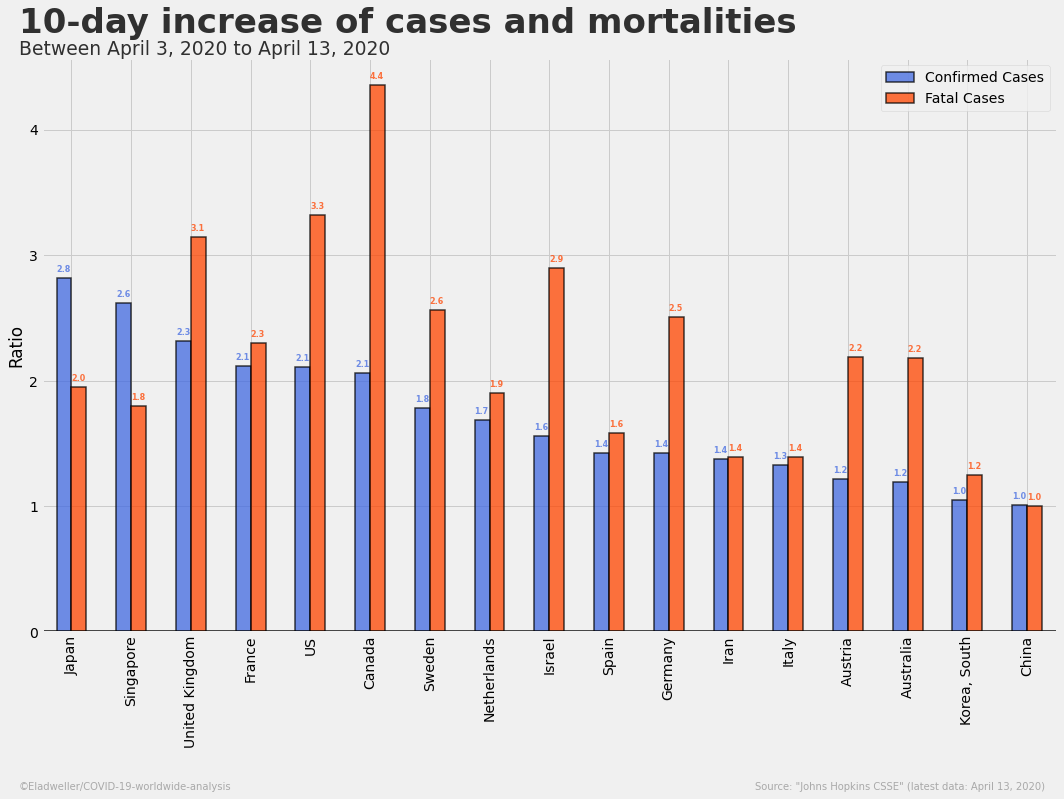

In [229]:
relevant_countries=['Israel','Austria', 'Australia', 'Canada', 'China', 'France', 'Germany', 'Sweden', 'Iran', 'Italy', 'Japan', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Singapore']

fig,ax = plt.subplots (figsize = (15,10))

subset = keep_relevant_countries(covid[covid.date == last_date],relevant_countries).set_index('country',drop=True).loc[:,['confirmed_10_day_change','dead_10_day_change']].rename({'confirmed_10_day_change':'Confirmed Cases','dead_10_day_change':'Fatal Cases'},axis=1)
plotting = subset.sort_values('Confirmed Cases', ascending=False).plot(kind='bar',ax=ax,linewidth=1.5,edgecolor = 'black',alpha = .75)

ax.set_ylabel ('Ratio')
ax.set_xlabel (None)
for patch in plotting.patches:
  x1,x2 = patch.get_xy()
  height = patch.get_height()
  color = patch.get_facecolor()
  ax.annotate(s = "{0:0.1f}".format(height),xy = (x1,height+.05),size = 8,c = color,weight='bold',ha='left')
plt.axhline(y = 0, color = 'black', alpha = .7)
# plt.title("Ratio Between Today and 10 Days Ago", loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
plt.tight_layout()
add_title(1.05,'10-day increase of cases and mortalities','Between {} to {}'.format(ctime(ten_days_ago),ctime(last_date)),offset=.045)
add_signature(-.04)

exporter('Ratio Between Today and 10 Days Ago')


## Total Confirmed Cases Plots

### Total confirmed cases by country

[15. 10.]
222
6.0 9 0.75 0.5


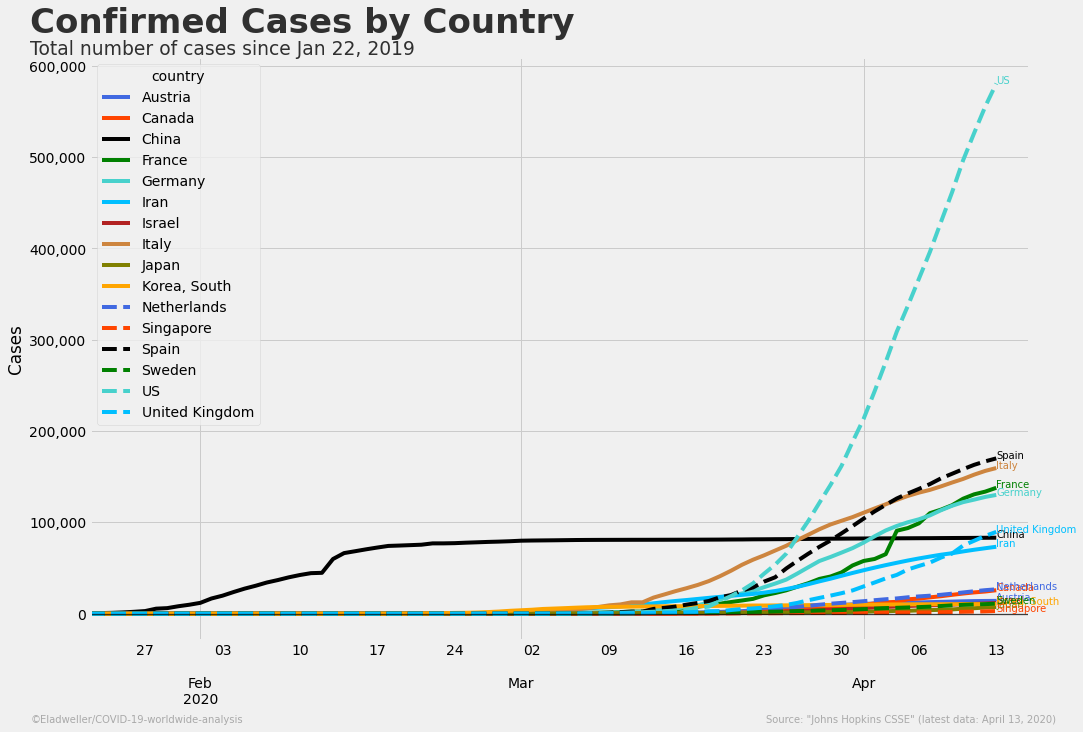

In [230]:
relevant_countries=['Israel','Austria','Canada', 'France', 'Germany','Iran', 'Italy', 'Japan', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Singapore', 'Sweden', 'China']
fig,ax = plt.subplots(figsize = (15,10))
subset = keep_relevant_countries(covid,relevant_countries).pivot(columns = 'country',index = 'date',values = 'confirmed')
plotted = subset.plot(ax = ax)
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
ax.set_xlabel('')
ax.set_ylabel('Cases')
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
expand_xlim(ax,right=3)
labelize(plotted)
add_title(.95,"Confirmed Cases by Country",'Total number of cases since Jan 22, 2019',offset=.045)
add_signature(-.0475)
exporter("Confirmed Cases by Country")


### Total confirmed cases progression in Israel

[15. 10.]
222
6.0 9 0.75 0.5


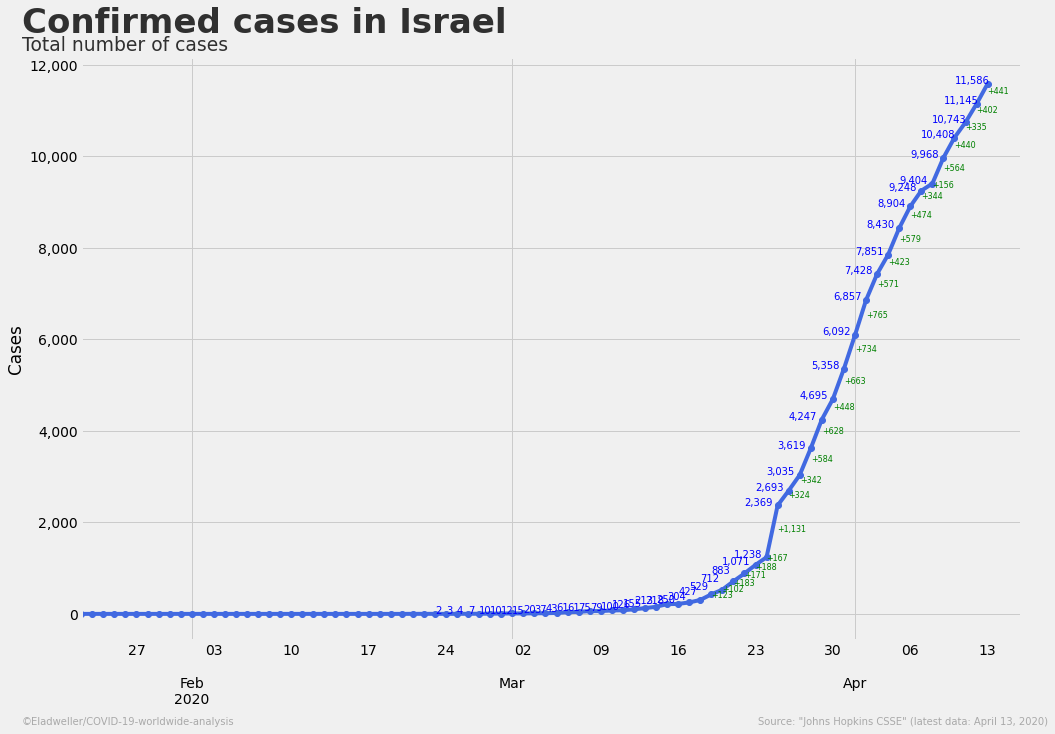

In [231]:
fig,ax = plt.subplots (figsize = (15,10))
plotted = Israel[Israel.confirmed>=0].confirmed.plot(style = '-o',markersize = 6,ax=ax)
old_x,old_y = 0,0
for _x,_y in plotted.lines[0].get_xydata():
  diff_x,diff_y = _x-old_x,_y-old_y
  if _y>1:
    ax.annotate(s = "{0:0,.0f}".format(_y), xy = (_x-3,_y+1), c = 'blue', size = 10)
  if diff_y>100:
    ax.annotate("+{0:0,.0f}".format(diff_y), xy=(_x-diff_x/2+1/2,_y-diff_y/2),c='green',ha='left',size = 8)
  old_x,old_y = _x,_y
ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1]+3)
ax.set_ylabel('Cases')
ax.set_xlabel('')
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
add_title(.95,'Confirmed cases in Israel','Total number of cases')
add_signature(-.05)
exporter('Confirmed Cases in Israel')


### Cases in Israel since the 100th confirmed case

[15. 10.]
222
6.0 9 0.75 0.5


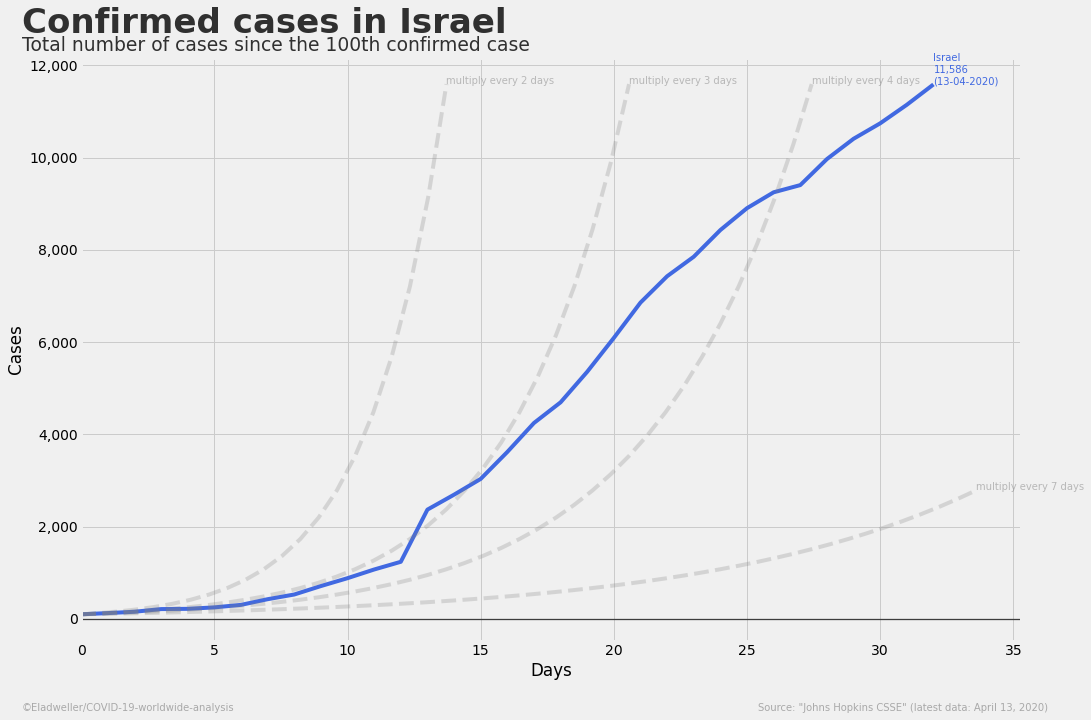

In [232]:
fig,ax = plt.subplots (figsize = (15,10))
plotting = Israel[Israel.confirmed >=100].reset_index(drop=True).confirmed.plot(ax=ax, label = 'Israel')

labelize(ax,show_values = True,show_date=True)
draw_exponent(ax,days = [2,3,4,7])
ax.set_ylabel('Cases')
ax.set_xlabel('Days')
ax.set_xlim(0,ax.get_xlim()[1])
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
# plt.title('Confirmed Cases (Since the 100th Case) in Israel', loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
add_title(.95,'Confirmed cases in Israel','Total number of cases since the 100th confirmed case')
add_signature(-.03)
exporter('Confirmed Cases in Israel','Since the 100th Case')


### Compare Israel to other countries at the same stage of progress, since the 100th confirmed case

[15. 10.]
222
6.0 9 0.75 0.5


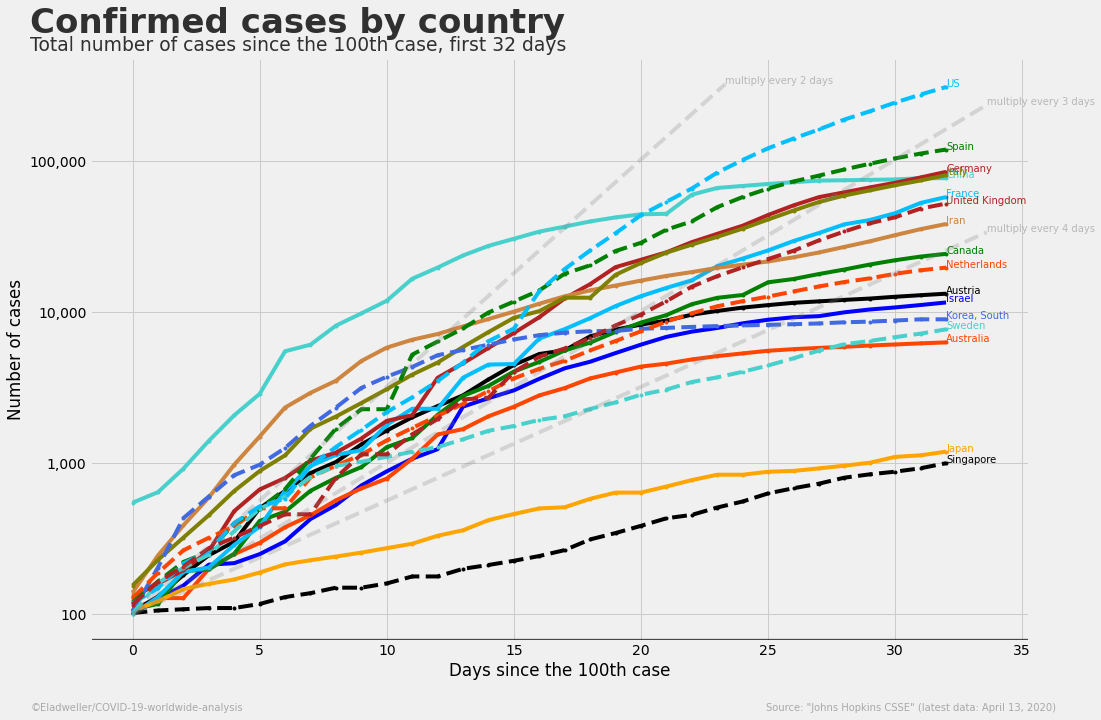

In [233]:
relevant_countries=['Austria', 'Australia', 'Canada', 'China', 'France', 'Germany','Iran', 'Italy', 'Japan', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Singapore', 'Sweden']

fig,ax = plt.subplots(figsize = (15,10))

subset = keep_relevant_countries(covid[covid.confirmed >= 100],relevant_countries,)
subset['cumcount'] = subset.groupby('country').cumcount()
il_plotting = Israel[Israel.confirmed >=100].reset_index(drop=True).confirmed
il_plottinng = il_plotting.plot(ax=ax, label = 'Israel',c='b')
plotting = subset.pivot(index = 'cumcount',columns='country',values = 'confirmed').loc[il_plotting.index,:].plot(ax = ax, alpha = 1,marker = '.',legend=False)
labelize(ax)
draw_exponent(ax,days = [2,3,4])
ax.set_ylabel('Number of cases')
ax.set_xlabel('Days since the 100th case')
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,y: '{0:0,.0f}'.format(x)))
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plot_hline(ax)
# plt.title('Confirmed Cases (Since the 100th Case), First {} Days'.format(len(il_plotting.index)-1), loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
add_title(.95,'Confirmed cases by country','Total number of cases since the 100th case, first {} days'.format(len(il_plotting.index)-1))
add_signature(-.03)
exporter('Confirmed Cases','Since the 100th Case, First {} Days'.format(len(il_plotting.index)-1))


### Countries' progression since the 100th confirmed case



[15. 10.]
222
6.0 9 0.75 0.5


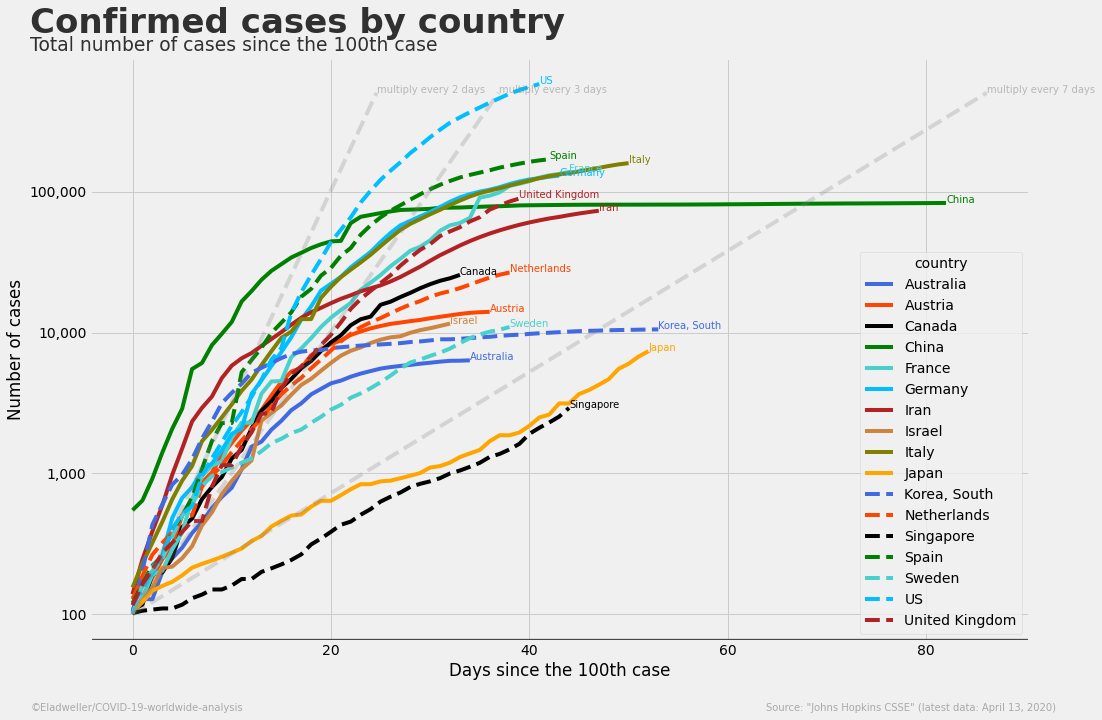

In [234]:
relevant_countries=['Austria', 'Australia', 'Canada', 'China', 'France', 'Germany','Iran', 'Israel', 'Italy', 'Japan', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Singapore', 'Sweden']
fig,ax = plt.subplots(figsize = (15,10))
subset = keep_relevant_countries(covid[covid.confirmed >= 100],relevant_countries)
subset['cumcount'] = subset.groupby('country').cumcount()
plotting = subset.pivot(index = 'cumcount',columns='country',values = 'confirmed').plot(ax = ax, alpha = 1)
labelize(ax)
draw_exponent(ax,days = [2,3,7])
ax.set_ylabel('Number of cases')
ax.set_xlabel('Days since the 100th case')
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,y: '{0:0,.0f}'.format(x)))
plt.axhline(y = plt.axis()[2]+2, color = 'black', linewidth = 1.3, alpha = .7)
# plt.title('Confirmed Cases (Since the 100th Case)', loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
# plt.text(x=.025,y=-.03,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.03,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_title(.95,'Confirmed cases by country','Total number of cases since the 100th case')
add_signature(-.03)
exporter('Confirmed Cases','Since the 100th Case')


## Total Fatalities Plots

### Total confirmed cases by country

[15. 10.]
222
6.0 9 0.75 0.5


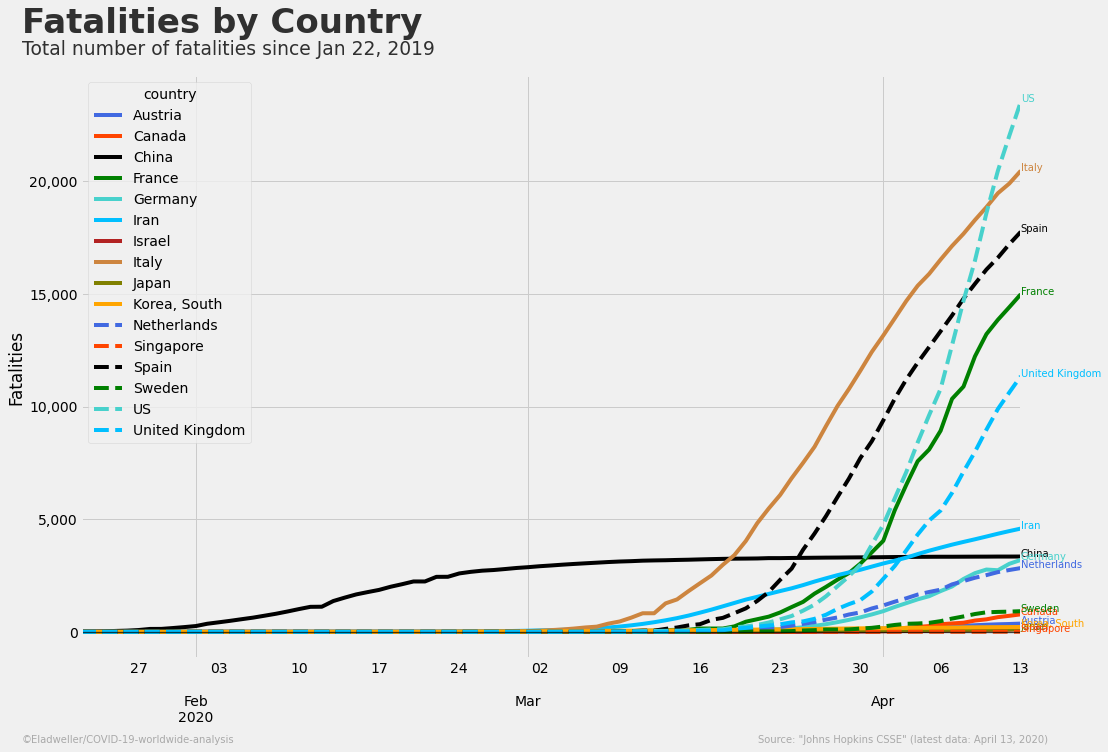

In [235]:
relevant_countries=['Israel','Austria','Canada', 'France', 'Germany','Iran', 'Italy', 'Japan', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Singapore', 'Sweden', 'China']
fig,ax = plt.subplots(figsize = (15,10))
subset = keep_relevant_countries(covid,relevant_countries).pivot(columns = 'country',index = 'date',values = 'dead')
plotted = subset.plot(ax = ax)
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
ax.set_xlabel('')
ax.set_ylabel('Fatalities')
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# expand_xlim(ax,right=3)
labelize(plotted)
# plt.title("Fatal Cases by Country", loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
# plt.text(x=.025,y=-.05,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.05,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_title(.975,"Fatalities by Country",'Total number of fatalities since Jan 22, 2019',offset=.045)
add_signature(-.05)

exporter("Fatal Cases by Country")

### Total fatal cases progression in Israel

[15. 10.]
222
6.0 9 0.75 0.5


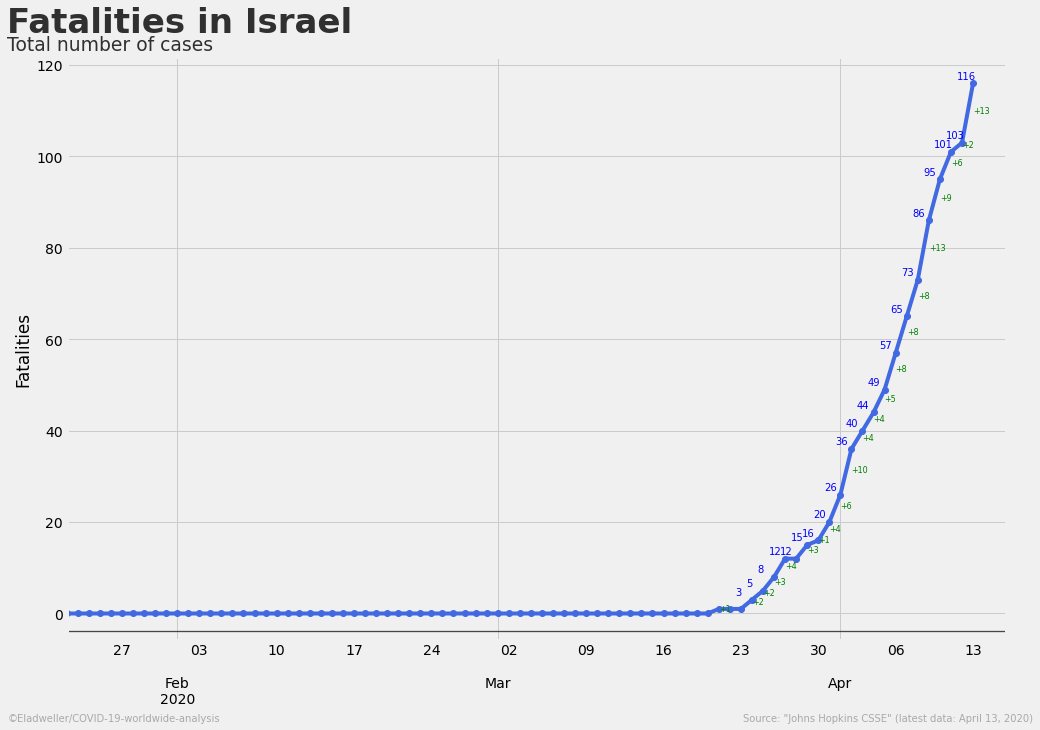

In [236]:
fig,ax = plt.subplots (figsize = (15,10))
plotted = Israel.dead.plot(style = '-o',markersize = 6,ax=ax)
old_x,old_y = 0,0
for _x,_y in plotted.lines[0].get_xydata():
  diff_x,diff_y = _x-old_x,_y-old_y
  if _y>1:
    ax.annotate(s = int(_y), xy = (_x-1.5,_y+1), c = 'blue', size = 10)
  if diff_y:
    ax.annotate("+{0:0,.0f}".format(diff_y), xy=(_x-diff_x/2+.5,_y-diff_y/2),c='green',ha='left',size = 8)
  old_x,old_y = _x,_y

ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1]+3)
ax.set_xlabel('')
ax.set_ylabel('Fatalities')
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.axhline(y = plt.axis()[2]+2, color = 'black', linewidth = 1.3, alpha = .7)
# plt.title("Fatal Cases in Israel (Latest Data: {})".format(datestring(last_date)), loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
# plt.text(x=.025,y=-.045,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.045,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_signature(-.045)
add_title(.95,'Fatalities in Israel','Total number of cases')
exporter('Fatal Cases in Israel')

### Fatal cases in Israel since the 10th fatal case

[15. 10.]
222
6.0 9 0.75 0.5


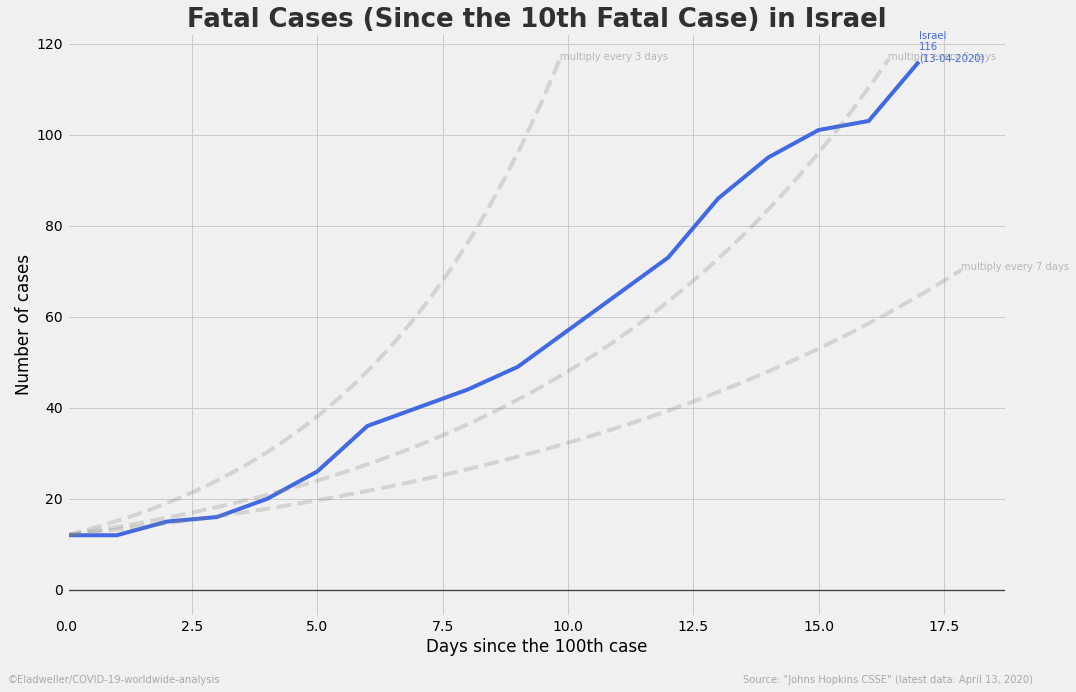

In [237]:
fig,ax = plt.subplots (figsize = (15,10))
to_plot = Israel[Israel.dead >=10].reset_index(drop=True).dead
plotting = to_plot.plot(ax=ax, label = 'Israel')
labelize(ax,show_values = True, show_date=True)
draw_exponent(ax,days = [3,5,7],start_value = to_plot[0])
ax.set_ylabel('Number of cases')
ax.set_xlabel('Days since the 100th case')
ax.set_xlim(0,ax.get_xlim()[1])
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plt.title('Fatal Cases (Since the 10th Fatal Case) in Israel', loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
# plt.text(x=.025,y=-.025,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.025,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_signature(-.025)

exporter('Fatal Cases in Israel','Since the 100th Case')


### Compare Israel to other countries at the same stage of progress, since the 10th fatal case

[15. 10.]
222
6.0 9 0.75 0.5


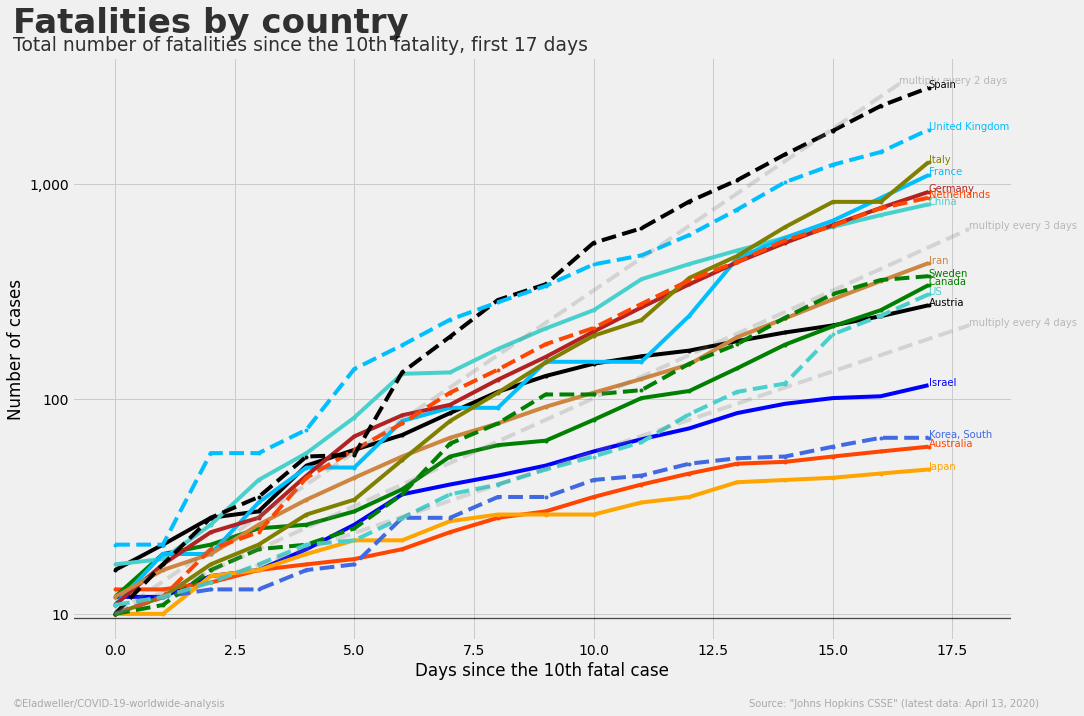

In [238]:
relevant_countries=['Austria', 'Australia', 'Canada', 'China', 'France', 'Germany','Iran', 'Italy', 'Japan', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Singapore', 'Sweden']

fig,ax = plt.subplots(figsize = (15,10))

subset = keep_relevant_countries(covid[covid.dead >= 10],relevant_countries,)
subset['cumcount'] = subset.groupby('country').cumcount()
il_plotting = Israel[Israel.dead >=10].reset_index(drop=True).dead
il_plottinng = il_plotting.plot(ax=ax, label = 'Israel',c='b')
plotting = subset.pivot(index = 'cumcount',columns='country',values = 'dead').loc[il_plotting.index,:].plot(ax = ax, alpha = 1,marker = '.',legend=False)
labelize(ax)
draw_exponent(ax,days = [2,3,4],start_value=10)
ax.set_ylabel('Number of cases')
ax.set_xlabel('Days since the 10th fatal case')
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,y: '{0:0,.0f}'.format(x)))
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plot_hline(ax)
# plt.title('Fatal Cases (Since the 10th Case), First {} Days'.format(len(il_plotting.index)-1), loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
# plt.text(x=.025,y=-.025,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.025,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_signature(-.025)
add_title(.95,'Fatalities by country','Total number of fatalities since the 10th fatality, first {} days'.format(len(il_plotting.index)-1))
exporter('Fatal Cases','Since the 10th Case, First {} Days'.format(len(il_plotting.index)-1))


### Countries' progression since the 10th fatal case


[15. 10.]
222
6.0 9 0.75 0.5


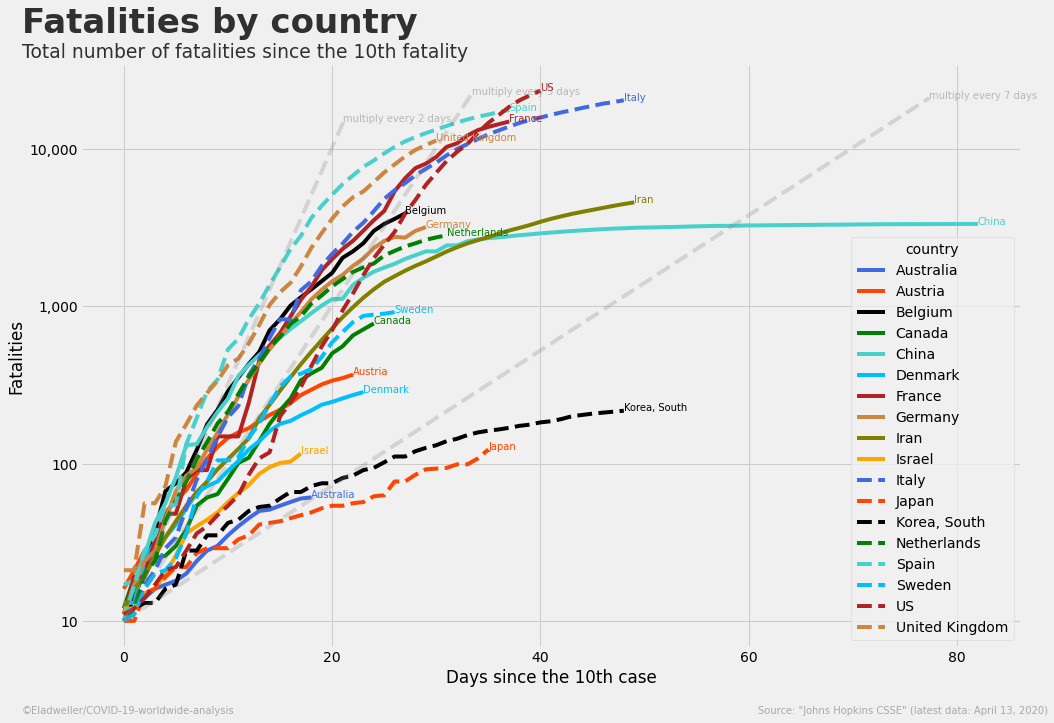

In [239]:
relevant_countries=['Austria', 'Australia','Belgium', 'Canada', 'China','Denmark', 'France', 'Germany','Iran', 'Israel', 'Italy', 'Japan', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Singapore', 'Sweden']

fig,ax = plt.subplots(figsize = (15,10))

subset = keep_relevant_countries(covid[covid.dead >= 10],relevant_countries)
subset['cumcount'] = subset.groupby('country').cumcount()
plotting = subset.pivot(index = 'cumcount',columns='country',values = 'dead').plot(ax = ax, alpha = 1)
labelize(ax)
draw_exponent(ax,days = [2,3,7],start_value = 10)
ax.set_ylabel('Fatalities')
ax.set_xlabel('Days since the 10th case')
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,y: '{0:0,.0f}'.format(x)))
# plt.title('Fatal Cases (Since the 10th Case)', loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
# plt.text(x=.025,y=-.025,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.025,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_signature(-.025)
add_title(.96,'Fatalities by country','Total number of fatalities since the 10th fatality',.05)
exporter('Fatal Cases','Since the 10th Case')


## Confirmed Cases per 1m

### Cases per 1m people by country

[15. 10.]
222
6.0 9 0.75 0.5


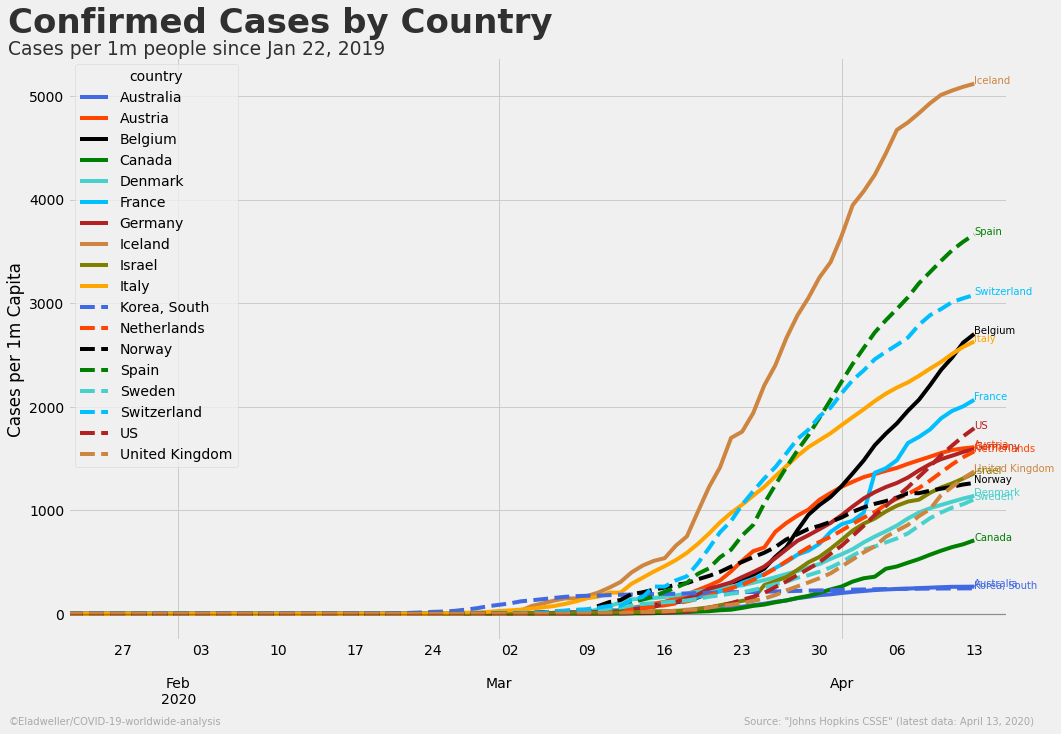

In [240]:
relevant_countries=['Israel','Australia','Austria','Belgium','Canada', 'Denmark', 'France', 'Germany', 'Iceland','Italy', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Norway', 'Sweden','Switzerland']
fig,ax = plt.subplots(figsize = (15,10))
subset = keep_relevant_countries(covid,relevant_countries).pivot (index = 'date', columns = 'country', values = 'confirmed_per_1m')
plotting = subset.plot(ax=ax,alpha = 1)
plt.xlabel('')
plt.ylabel('Cases per 1m Capita')
labelize(plotting)
expand_xlim(ax,right=3)
plt.axhline(y = 0, color = 'black',linewidth = 1.3, alpha = .3)
# plt.title("Confirmed Cases by Country (per 1m People)", loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
# plt.text(x=.025,y=-.05,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.05,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_signature(-.05)
add_title(.95,"Confirmed Cases by Country",'Cases per 1m people since Jan 22, 2019',offset=.045)
exporter('Confirmed Cases by Country','per 1m People')

### Cases per 1m people after reaching a 10 cases per 1m people threshold

[15. 10.]
222
6.0 9 0.75 0.5


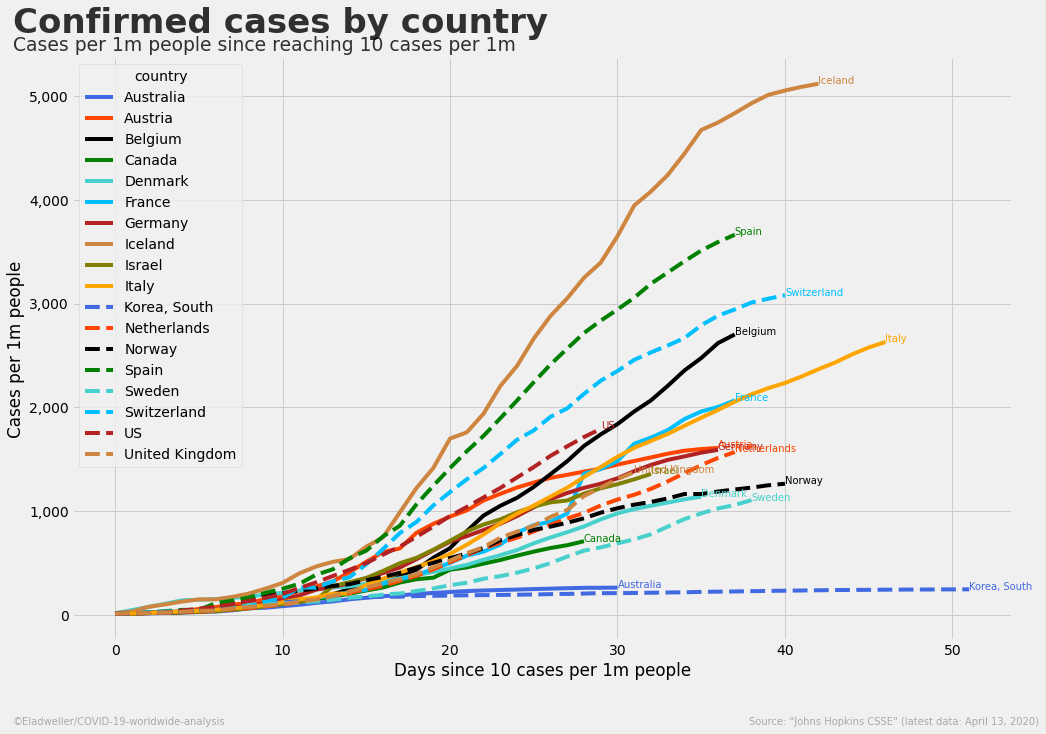

In [241]:
fig ,ax = plt.subplots(figsize = (15,10))
relevant_countries=['Israel','Australia','Austria','Belgium','Canada', 'Denmark', 'France', 'Germany', 'Iceland','Italy', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Norway', 'Sweden','Switzerland']

subset = keep_relevant_countries(covid[covid.confirmed_per_1m>10],relevant_countries)
subset['cumcount'] = subset.groupby('country').cumcount()
plotting = subset.pivot(index = 'cumcount',columns = 'country', values='confirmed_per_1m').plot(ax=ax,alpha = 1)
labelize(ax)
ax.set_xlabel('Days since 10 cases per 1m people')
ax.set_ylabel('Cases per 1m people')
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# plt.text(x=.025,y=-.05,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.05,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_signature(-.05)
add_title(.95,'Confirmed cases by country','Cases per 1m people since reaching 10 cases per 1m')
# plt.title("Cases per 1m People (Since Reaching 10 Cases per 1m)", loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
exporter('Cases per 1m People','Since Reaching 10 Cases per 1m')

## Fatal Cases per 1m

### Fatal cases per 1m people

[15. 10.]
222
6.0 9 0.75 0.5


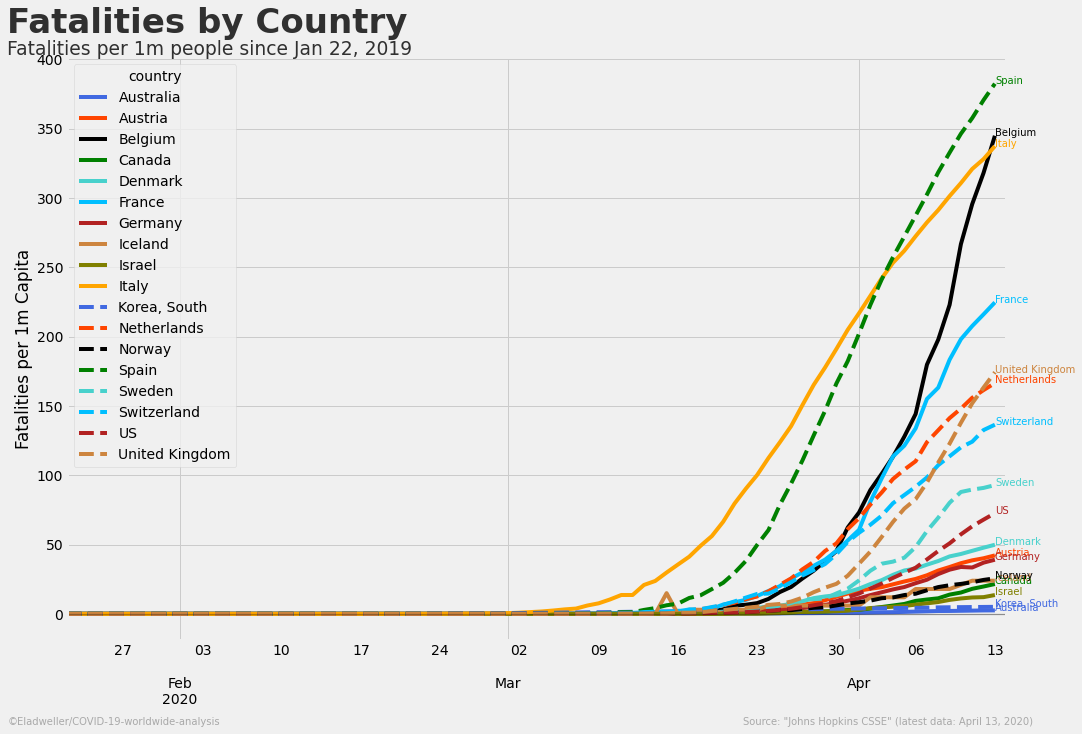

In [242]:
relevant_countries=['Israel','Australia','Austria','Belgium','Canada', 'Denmark', 'France', 'Germany', 'Iceland','Italy', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Norway', 'Sweden','Switzerland']
fig,ax = plt.subplots(figsize = (15,10))

subset = keep_relevant_countries(covid,relevant_countries).pivot (index = 'date', columns = 'country', values = 'dead_per_1m')
plotting = subset.plot(ax=ax,alpha = 1)
plt.xlabel('')
plt.ylabel('Fatalities per 1m Capita')
labelize(plotting)
expand_xlim(ax,right=1)
plt.axhline(y = 0, color = 'black',linewidth = 1.3, alpha = .3)
# plt.title("Fatal Cases by Country (per 1m People)", loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
# plt.text(x=.025,y=-.05,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.05,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_signature(-.05)
add_title(.95,"Fatalities by Country",'Fatalities per 1m people since Jan 22, 2019',offset=.045)

exporter('Fatal Cases by Country','per 1m People')


### Fatal per 1m people after reaching a 3 cases per 1m people threshold

[15. 10.]
222
6.0 9 0.75 0.5


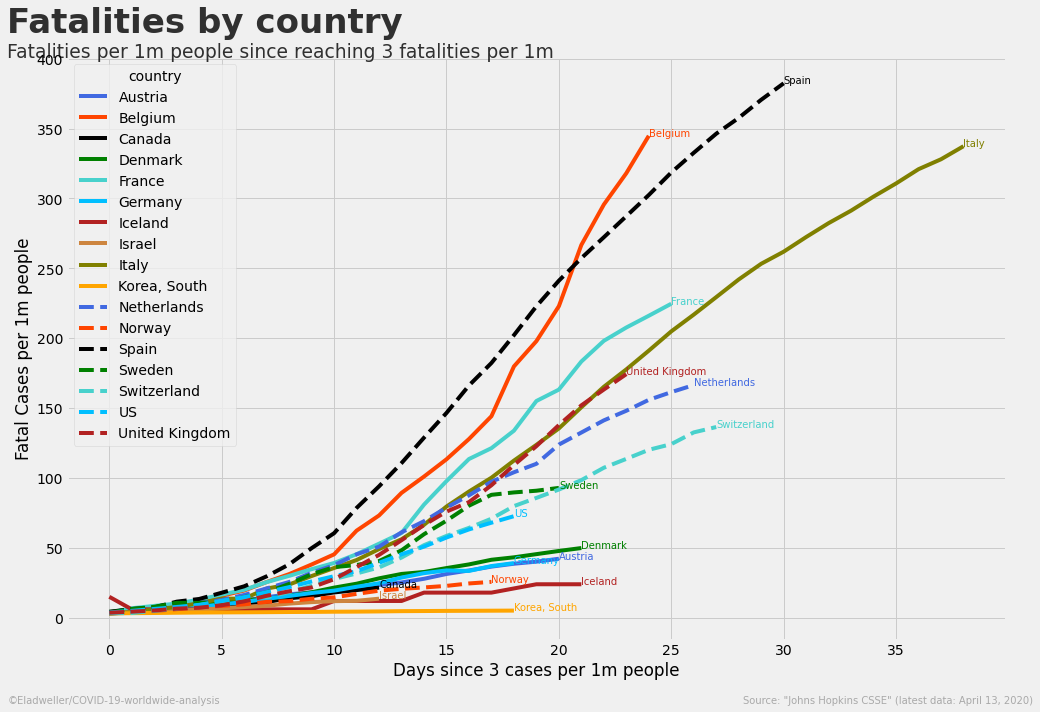

In [243]:
fig ,ax = plt.subplots(figsize = (15,10))
relevant_countries=['Israel','Australia','Austria','Belgium','Canada', 'Denmark', 'France', 'Germany', 'Iceland','Italy', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Norway', 'Sweden','Switzerland']

subset = keep_relevant_countries(covid[covid.dead_per_1m>3],relevant_countries)
subset['cumcount'] = subset.groupby('country').cumcount()
plotting = subset.pivot(index = 'cumcount',columns = 'country', values='dead_per_1m').plot(ax=ax,alpha = 1)
labelize(ax)
ax.set_xlabel('Days since 3 cases per 1m people')
ax.set_ylabel('Fatal Cases per 1m people')
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# plt.title("Fatal Cases per 1m People (Since Reaching 3 Cases per 1m)", loc = 'center',fontdict={'size':26,'weight':'bold','alpha' :.8})
# plt.text(x=.025,y=-.02,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.02,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_title(.95,'Fatalities by country','Fatalities per 1m people since reaching 3 fatalities per 1m',0.05)
add_signature(-.02)
exporter('Fatal Cases per 1m People','Since Reaching 3 Cases per 1m')

## Mortality Rates

### Cases per capita and Mortality per capita

[15. 10.]
222
6.0 9 0.75 0.5


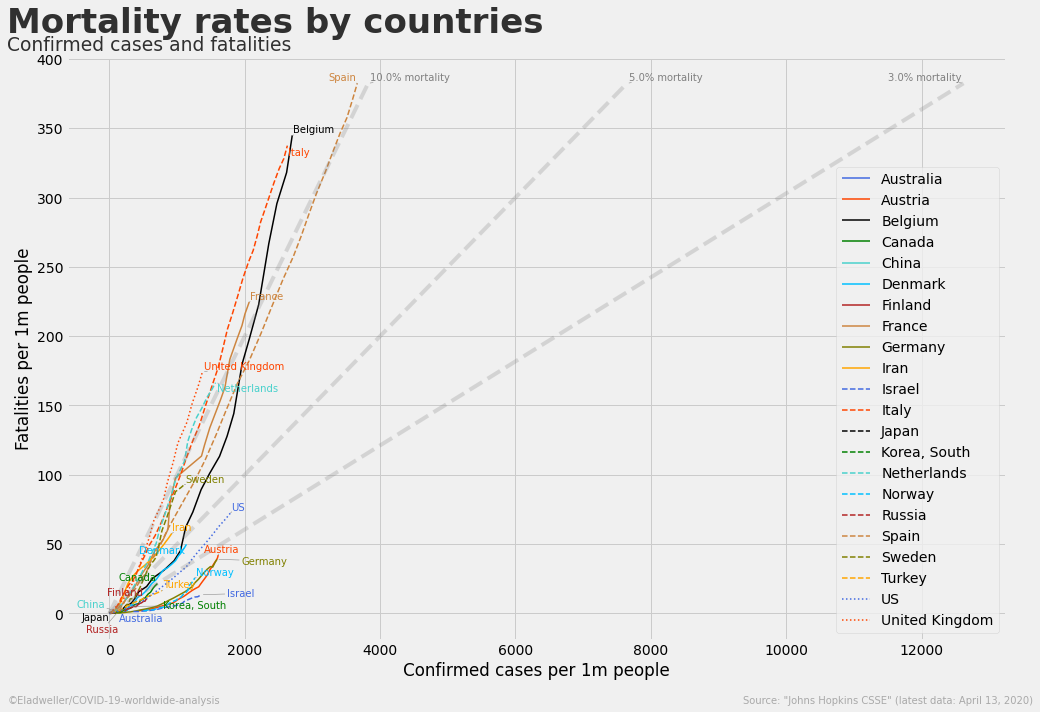

In [244]:
relevant_countries=['Austria', 'Australia','Belgium', 'Canada', 'China','Denmark','Finland', 'France', 'Germany','Israel','Iran', 'Italy', 'Japan', 'Korea, South','Netherlands','Norway','Russia','Spain','Turkey', 'US', 'United Kingdom', 'Singapore', 'Sweden']

fig,ax = plt.subplots(figsize = (15,10))

subset = keep_relevant_countries(covid[covid.dead>=10],relevant_countries)
for label,group in subset.groupby('country'):
  group.plot(x='confirmed_per_1m',y='dead_per_1m',ax = ax, label = label,alpha = 1,linewidth = 1.5)

for per in [33,20,10]:
  y = np.linspace(0,np.max(subset.dead_per_1m))
  x = per*y
  ax.plot(x,y,ls='--', color='grey', label="{0:0.1f}% mortality".format(100/per), alpha = .25)
labelize(ax,adj_text=True)
ax.set_ylabel('Fatalities per 1m people')
ax.set_xlabel('Confirmed cases per 1m people')
# plt.title('Cases and Mortality per 1m People',loc = 'center',fontdict = {'size' : 26,'weight' : 'bold'})
# plt.text(x=.025,y=-.02,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.02,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_signature(-.02)
add_title(.95,'Mortality rates by countries','Confirmed cases and fatalities')
exporter('Cases and Mortality per 1m People')

### Mortality rates as number of cases rise

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in double_scalars


[12.  8.]
222
6.0 9 0.75 0.5


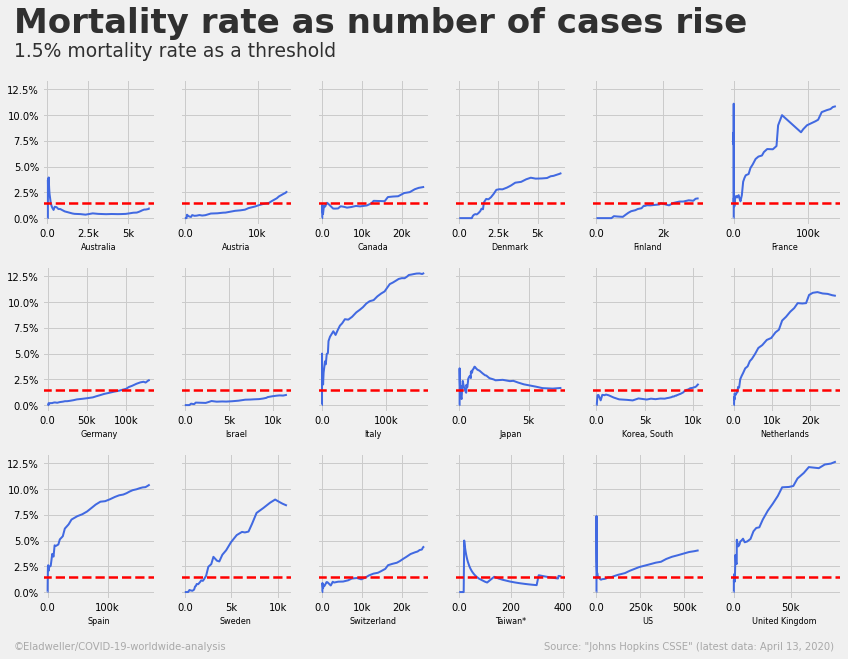

In [245]:
nrows = 3
ncols = 6
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharey=True,figsize = (12,8))
fig.tight_layout()
relevant_countries=['Israel','Australia','Austria','Canada', 'Denmark', 'France', 'Germany', 'Italy', 'Japan', 'Korea, South','Netherlands','Finland','Spain', 'US', 'United Kingdom', 'Sweden','Switzerland','Taiwan*']
subset = keep_relevant_countries(covid,relevant_countries).loc[:,['country','confirmed','mortality_rate']]
for idx,(label,group) in enumerate(subset.groupby('country')):
  ax = axes[idx//ncols,idx%ncols]
  group.plot(x='confirmed',y='mortality_rate',ax=ax,legend = None,lw=2)
  ax.axhline(y=0.015, color='r',linewidth = 2.5, linestyle='--')
  ax.set_xlabel(label,fontdict={'size':8})
  ax.tick_params(axis='both', which='major', labelsize=10)
  ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(return_k))
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()])
plt.tight_layout()
# plt.suptitle("Fatality Rate per Number of Confirmed Cases", y= 1,ha = 'center',fontsize = 26, fontweight = 'bold',alpha = .8)
# plt.text(x=.025,y=-.02,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.02,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_title(1.1,'Mortality rate as number of cases rise','1.5% mortality rate as a threshold',.06)
add_signature(-.02)
exporter('Incrasing number of cases vs mortality rate')

## Daily Changes

### Growth rate in *confirmed cases* since the the 100th case

[15. 10.]
222
6.0 9 0.75 0.5


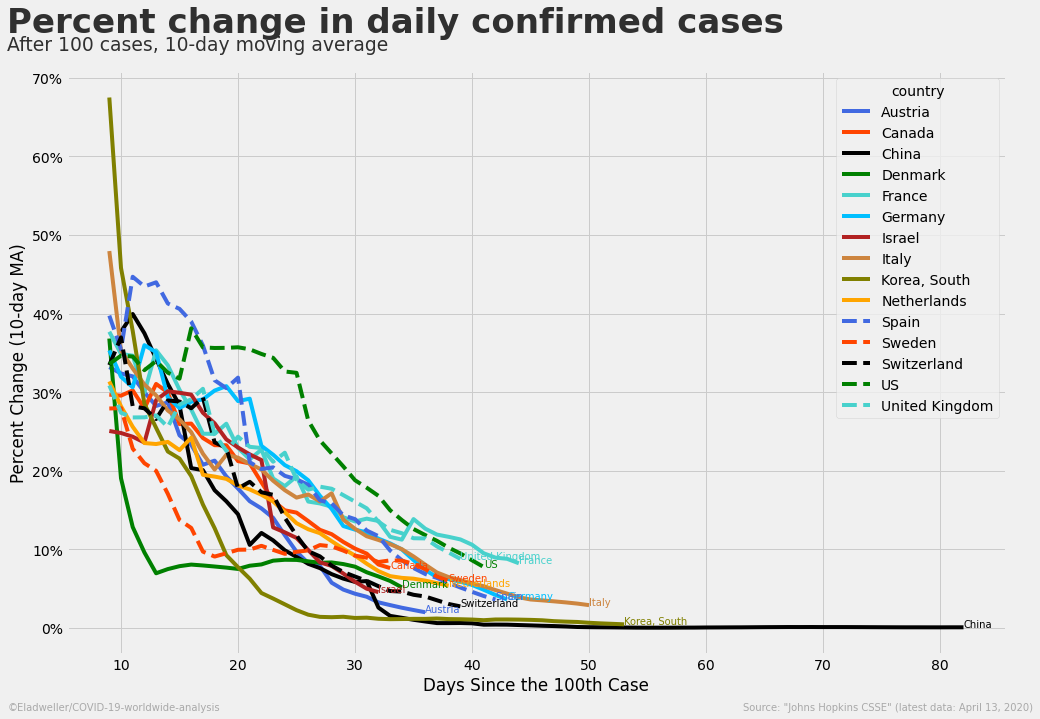

In [246]:
fig,ax = plt.subplots(figsize=(15,10))
relevant_countries=['Israel','Austria','Canada', 'Denmark', 'France', 'Germany', 'Italy', 'Korea, South','Netherlands','Spain', 'United Kingdom', 'Sweden','Switzerland', 'US', 'China']
subset = keep_relevant_countries(covid[covid.confirmed >= 100],relevant_countries)
subset['cumcount'] = subset.groupby('country').cumcount()
subset.pivot(index = 'cumcount', columns = 'country', values = 'confirmed_daily_change').rolling(10).mean().plot(ax=ax)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.set_ylabel('Percent Change (10-day MA)')
ax.set_xlabel('Days Since the 100th Case')
labelize(ax)
# plt.title('Percent Change in Cases (after 100 cases, 10-days moving average)', loc = 'center',fontdict={'size':23,'weight':'bold','alpha' :.8})
# plt.text(x=.025,y=-.005,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.005,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_signature(-.01)
add_title(.97,'Percent change in daily confirmed cases','After 100 cases, 10-day moving average')
exporter('Percent Change in Cases','Since the 100th case, 10-days moving average')

### Growth rate in *fatal cases* since the the 10th case

[15. 10.]
222
6.0 9 0.75 0.5


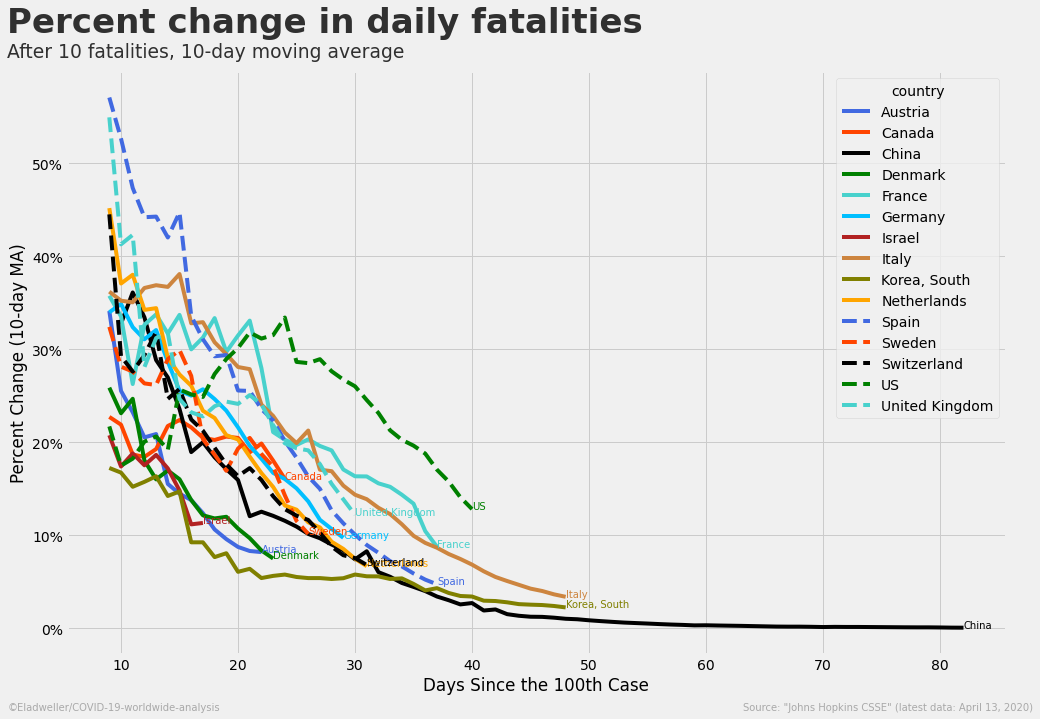

In [247]:
relevant_countries=['Israel','Austria','Canada', 'Denmark', 'France', 'Germany', 'Italy', 'Korea, South','Netherlands','Spain', 'United Kingdom', 'Sweden','Switzerland', 'US', 'China']
ma_period = 10


fig,ax = plt.subplots(figsize=(15,10))

subset = keep_relevant_countries(covid[covid.dead >= 10],relevant_countries)
subset['cumcount'] = subset.groupby('country').cumcount()
subset.pivot(index = 'cumcount', columns = 'country', values = 'dead_daily_change').rolling(ma_period).mean().dropna(how='all',axis=1).plot(ax=ax)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.set_ylabel('Percent Change ({}-day MA)'.format(ma_period))
ax.set_xlabel('Days Since the 100th Case')
labelize(ax)
# plt.title('Percent Change in Fatal Cases (After 10 Fatal Cases, {}-days Moving Average)'.format(ma_period), loc = 'center',fontdict={'size':23,'weight':'bold','alpha' :.8})
# plt.text(x=.025,y=-.005,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.005,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_signature(-.01)
add_title(.97,'Percent change in daily fatalities','After 10 fatalities, 10-day moving average',.05)
exporter('Percent Change in Fatal Cases', 'After 10 Fatal Cases, {}-days Moving Average'.format(ma_period))

### Plot daily cases since the first day with 30 confirmed

[15. 10.]
222
6.0 9 0.75 0.5


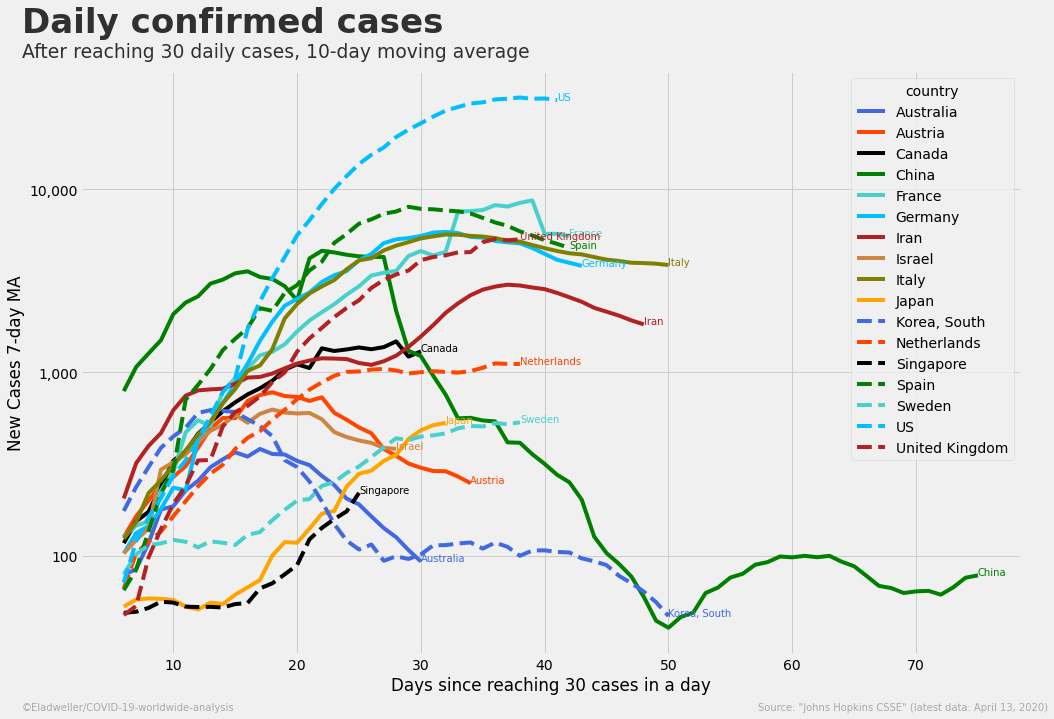

In [248]:
relevant_countries=['Austria', 'Australia', 'Canada', 'China', 'France', 'Germany','Israel','Iran', 'Italy', 'Japan', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Singapore', 'Sweden']
ma_period = 7

fig,ax = plt.subplots(figsize = (15,10))
subset = keep_relevant_countries(covid[covid.confirmed_daily >= 30],relevant_countries)
subset['cumcount'] = subset.groupby('country').cumcount()
plotting = subset.pivot(index = 'cumcount',columns='country',values = 'confirmed_daily').rolling(ma_period).mean().dropna(how='all',axis=1).plot(ax = ax, alpha = 1)
labelize(ax)
ax.set_ylabel('New Cases {}-day MA'.format(ma_period))
ax.set_xlabel('Days since reaching 30 cases in a day')
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,y: '{0:0,.0f}'.format(x)))
# plt.title('New Confirmed Cases per Day (Since Reaching 30, {}-day Moving Average)'.format(ma_period),loc = 'center',fontdict = {'size' : 23,'weight' : 'bold'})
# plt.text(x=.025,y=-.005,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.005,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_title(.97,'Daily confirmed cases','After reaching 30 daily cases, 10-day moving average',.05)
add_signature(-.01)
exporter("New Confirmed Cases per Day","Since Reaching 30, {}-day Moving Average".format(ma_period))

### Plot daily mortality since the first day with 3 mortalities

[15. 10.]
222
6.0 9 0.75 0.5


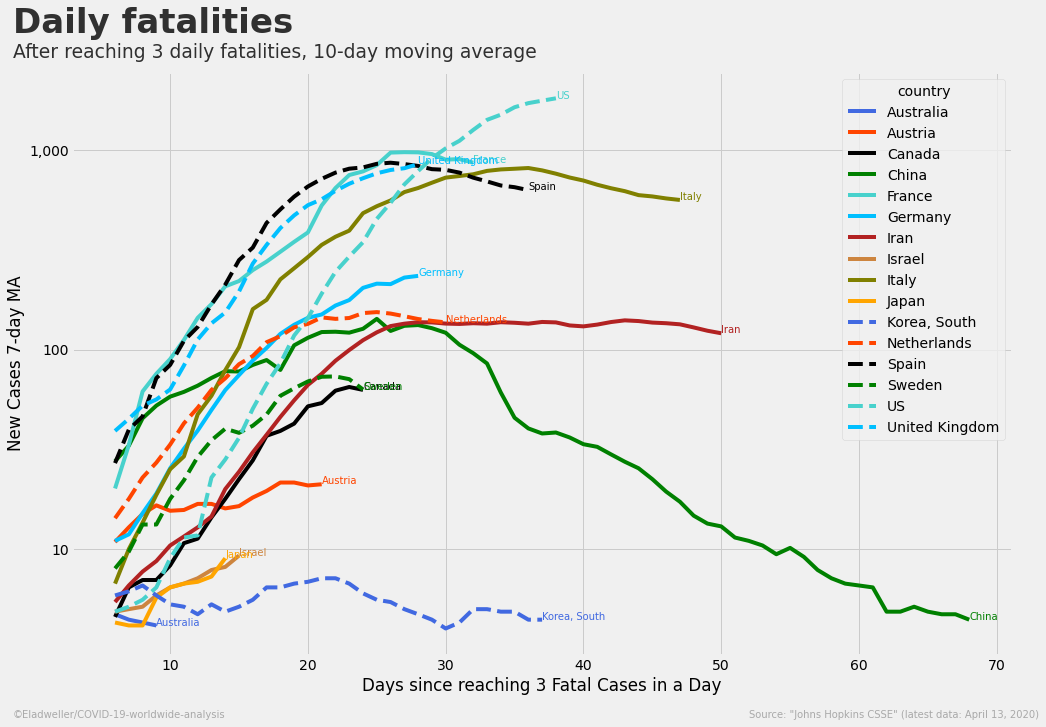

In [249]:
relevant_countries=['Austria', 'Australia', 'Canada', 'China', 'France', 'Germany','Israel','Iran', 'Italy', 'Japan', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Singapore', 'Sweden']
ma_period = 7

fig,ax = plt.subplots(figsize = (15,10))
subset = keep_relevant_countries(covid[covid.dead_daily >= 3],relevant_countries)
subset['cumcount'] = subset.groupby('country').cumcount()
plotting = subset.pivot(index = 'cumcount',columns='country',values = 'dead_daily').rolling(ma_period).mean().dropna(how='all',axis=1).plot(ax = ax)
labelize(ax)
ax.set_ylabel('New Cases {}-day MA'.format(ma_period))
ax.set_xlabel('Days since reaching 3 Fatal Cases in a Day')
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,y: '{0:0,.0f}'.format(x)))
# plt.title('New Fatal Cases per Day (Since Reaching 3, {}-day Moving Average)'.format(ma_period),loc = 'center',fontdict = {'size' : 23,'weight' : 'bold'})
# plt.text(x=.025,y=-.005,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.005,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_signature(-.02)
add_title(.97,'Daily fatalities','After reaching 3 daily fatalities, 10-day moving average',.05)
exporter('New Fatal Cases per Day', 'Since Reaching 3, {}-day Moving Average'.format(ma_period))

## Pandemic Progression

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in double_scalars


[13.  8.]
222
5.538461538461538 9 0.9807692307692308 0.5


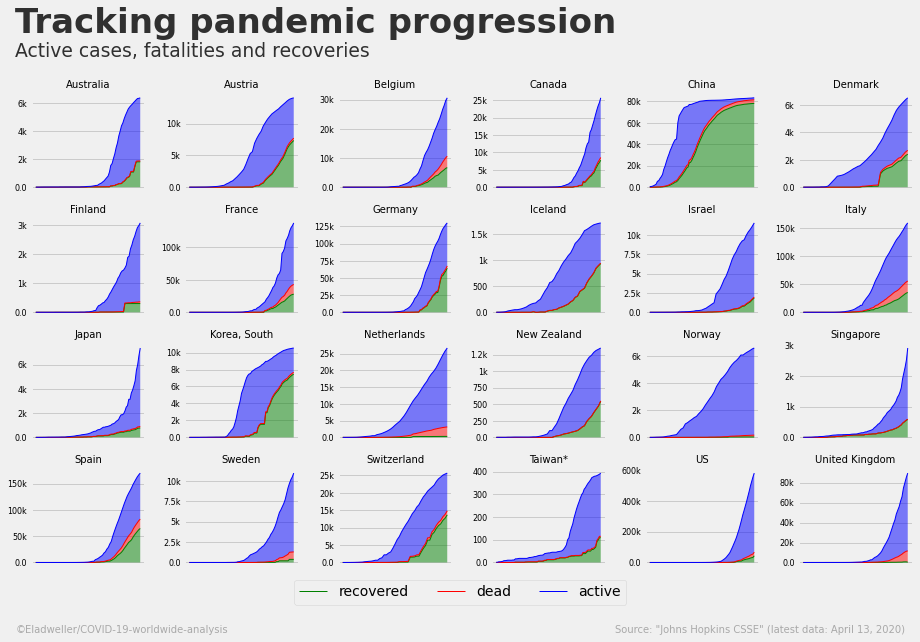

In [250]:
colors = ['g','r','b']
nrows = 4
ncols = 6
fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=(13,8))
relevant_countries=['Israel','Australia','Austria','Belgium','Canada','China', 'Denmark', 'Finland','France', 'Germany','Iceland', 'Italy', 'Japan','Norway', 'Korea, South','Netherlands','New Zealand','Spain', 'US', 'United Kingdom', 'Sweden','Switzerland','Singapore','Taiwan*']
subset = keep_relevant_countries(covid[covid.confirmed>0],relevant_countries).loc[:,['country','recovered','dead','active']]
for idx,(label,group) in enumerate(subset.groupby('country')):
  ax = axes[idx//ncols,idx%ncols]
  ax.set_xlabel(None)
  ax.tick_params(axis='both', which='major', labelsize=8)
  ax.set_xticklabels([])
  ax.set_title(label,fontsize=10)
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(return_k))
  gs = group.loc[:,['recovered','dead','active']].cumsum(axis=1)
  gs.plot(ax=ax, color=colors, lw=1,legend = None)
  ax.fill_between(gs.index,gs.recovered,alpha = .5, facecolor='g')
  ax.fill_between(gs.index,gs.dead,gs.recovered,alpha = .5, facecolor='r')
  ax.fill_between(gs.index,gs.active,gs.dead,alpha = .5, facecolor='b')
  ax.set_xticks([])

handles, labels = ax.get_legend_handles_labels()
plt.tight_layout()

plt.legend( handles, labels, loc = 'lower center', bbox_to_anchor = (0,-0.05,1,1),
            bbox_transform = plt.gcf().transFigure,ncol=3 )
# plt.suptitle('Pandemic Progression',ha = 'center',fontsize = 26,fontweight = 'bold')
# plt.text(x=.025,y=-.09,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.09,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
plt.subplots_adjust(top=0.85)
add_title(1,'Tracking pandemic progression','Active cases, fatalities and recoveries',.06)
add_signature(-.09)
exporter('Pandemic Progression')

### Pandemic Status

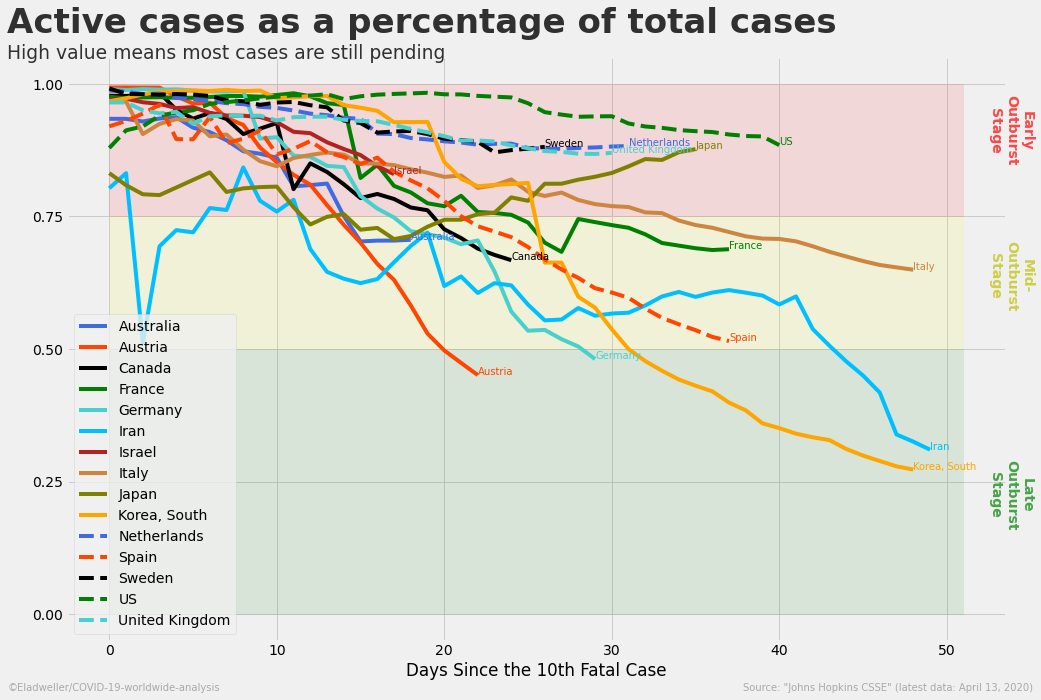

In [251]:
covid['progression'] = covid.active / covid.confirmed

relevant_countries=['Austria', 'Australia', 'Canada', 'France', 'Germany','Israel','Iran', 'Italy', 'Japan', 'Korea, South','Netherlands','Spain', 'US', 'United Kingdom', 'Singapore', 'Sweden']

fig,ax = plt.subplots(figsize = (15,10))

subset = keep_relevant_countries(covid[covid.dead>=10],relevant_countries)
subset['days_since'] = subset.groupby('country').cumcount()
p = subset.pivot('days_since','country','progression').plot(ax=ax)
ax.legend(loc='lower left')
r_edge = ax.get_xlim()[1]
b_edge = ax.get_ylim()[0]
ax.fill_between(np.linspace(0,int(r_edge)),0,0.5, alpha = 0.1, color='green')
ax.fill_between(np.linspace(0,int(r_edge)),.5,0.75, alpha = 0.1, color='yellow')
ax.fill_between(np.linspace(0,int(r_edge)),.75,1, alpha = 0.1, color='red')
plt.text(x = 1.005, y= 0.875, s='Early\nOutburst\nStage', rotation = 270, va='center', ha='center', wrap=True, color = 'r', alpha = .7, weight = 'bold',transform=ax.transAxes)
plt.text(x = 1.005, y= 0.625, s='Mid-\nOutburst\nStage', rotation = 270, va='center', ha='center', wrap=True, color = 'y', alpha = .7, weight = 'bold',transform=ax.transAxes)
plt.text(x = 1.005, y= 0.25, s='Late\nOutburst\nStage', rotation = 270, va='center', ha='center', wrap=True, color = 'g', alpha = .7, weight = 'bold',transform=ax.transAxes)
ax.set_yticks([0,.25,.5,.75,1])
ax.set_xlabel('Days Since the 10th Fatal Case')
# plt.suptitle('Pandemic Status',ha = 'center',fontsize = 26,fontweight = 'bold')
labelize(ax)

# plt.text(x=.025,y=-.0025,s='©Eladweller/COVID-19-worldwide-analysis',ha = 'left', va = 'bottom', transform=fig.transFigure,color='darkgrey')
# plt.text(x=.975,y=-.0025,s='Source: "Johns Hopkins CSSE"',ha = 'right', va = 'bottom', transform=fig.transFigure,color='darkgrey')
add_signature(-.0025)
add_title(.95,'Active cases as a percentage of total cases','High value means most cases are still pending',.051)
# plt.tight_layout()
# exporter('Outbrake Status',"Active Cases as a Percentage of Total Cases")

# Update the results in GitHub

In [0]:
GIT_REPOSITORY = "COVID-19-worldwide-analysis" 
MY_GOOGLE_DRIVE_PATH = ROOT
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

readme_intro = """# COVID-19-worldwide-analysis

Graphical analysis of COVID-19 international data in order to follow the epidemic's progression in the developed world. The notebook is updated daily from "2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE" (https://github.com/CSSEGISandData/COVID-19).

<h2> Files and Folders </h2>
<h3> Files </h3>

<h3> Folders </h3>
<b><i>Data/</i></b><br>
Conatains the data files<br>
<b><i>Presentations/</i></b><br>
PPTX file with the graphs, ready for distribution<br>
<b><i>Graphs/</i></b><br>
All the produces graphs<br>

***
<h2> Results </h2>"""

with open(ROOT+"README.md",'w') as file1:
  file1.write("<b>Latest Update: {}, Latest Data: {}</b>\n".format(datetime.now(),datestring(last_date)))
  file1.write(readme_intro)
  for i in README:
    file1.write('<h3>{}<h3>\n'.format(i[0]))
    file1.write('<img src="{}{}.png" width="700">\n'.format(graph_folder_name,i[0]))

In [253]:
with open(ROOT+'github.txt','r') as file1:
  GIT_USERNAME,GIT_PASSWORD,GIT_TOKEN = next(file1).split(",")
with open(ROOT+'.gitignore','w') as file1:
  file1.write('github.txt')

print("PROJECT_PATH: ", PROJECT_PATH)   

GIT_PATH = "https://{}:{}@github.com/{}/{}.git".format(GIT_USERNAME,GIT_PASSWORD,GIT_USERNAME,GIT_REPOSITORY)

PROJECT_PATH:  /content/drive/My Drive/Coronavirus/


In [254]:
import urllib
notebook_url = "https://github.com/Eladweller/COVID-19-worldwide-analysis/blob/master/Covid_19_Analysis.ipynb"
urllib.request.urlretrieve(notebook_url,PROJECT_PATH+notebook_url.split('/')[-1])

%cd "{PROJECT_PATH}"
!pwd
!git init
# !git rm --cached drive/My Drive/Coronavirus
!git add .
# !git pull --rebase master
# !git stash save
# !git pull -r
# !git stash pop
!git config --global user.email "elad.weller@mail.huji.ac.il"
!git config --global user.name "Elad Weller"
!git commit -m "commited at {NOW}"
# print(GIT_PATH)
# !git remote set-url origin "{GIT_PATH}"
!git remote add origin "{GIT_PATH}"
# !git push origin master
!git push --force origin master

/content/drive/My Drive/Coronavirus
/content/drive/My Drive/Coronavirus
Reinitialized existing Git repository in /content/drive/My Drive/Coronavirus/.git/
[master 141f622] commited at 2020-04-14 12:12:51.843260
 6 files changed, 8 insertions(+), 8 deletions(-)
 rewrite New_Graphs/Changes in Israel's Rankings from Last Week.png (98%)
 rewrite New_Graphs/Israel on Key Metrics.png (98%)
 rewrite New_Graphs/Main indicators in Israel(Progression in the last week).png (98%)
 rewrite Presentations/COVID-19 13-04-2020.pptx (99%)
fatal: remote origin already exists.
Counting objects: 10, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (10/10), done.
Writing objects: 100% (10/10), 264.40 KiB | 11.02 MiB/s, done.
Total 10 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/Eladweller/COVID-19-worldwide-analysis.git
   65e35cb..141f622  master -> master


# BETA